## Loading datasets (UCF50)

In [1]:
import sys
import torch
import torchvision
import numpy as np
import pandas as pd
import cv2
import matplotlib
import sklearn
def print_versions():
    print("Python:", sys.version.split()[0])
    print("PyTorch:", torch.__version__)
    print("TorchVision:", torchvision.__version__)
    print("NumPy:", np.__version__)
    print("Pandas:", pd.__version__)
    print("OpenCV:", cv2.__version__)
    print("Matplotlib:", matplotlib.__version__)
    print("scikit-learn:", sklearn.__version__)
    
    # CUDA info
    print("CUDA Available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("CUDA Version:", torch.version.cuda)
        print("cuDNN Version:", torch.backends.cudnn.version())
        print("GPU Name:", torch.cuda.get_device_name(0))
        print("Total GPU Memory (MiB):", round(torch.cuda.get_device_properties(0).total_memory / (1024**2), 2))
        print("Allocated GPU Memory (MiB):", round(torch.cuda.memory_allocated(0) / (1024**2), 2))
        print("Cached GPU Memory (MiB):", round(torch.cuda.memory_reserved(0) / (1024**2), 2))
print_versions()

Python: 3.11.13
PyTorch: 2.6.0+cu124
TorchVision: 0.21.0+cu124
NumPy: 1.26.4
Pandas: 2.2.3
OpenCV: 4.12.0
Matplotlib: 3.7.2
scikit-learn: 1.2.2
CUDA Available: False


In [8]:
import kagglehub

# Download latest version
ucf50_path = kagglehub.dataset_download("pypiahmad/realistic-action-recognition-ucf50")

print("Path to dataset files:", ucf50_path)

Path to dataset files: /kaggle/input/realistic-action-recognition-ucf50


In [3]:
import os

ucf50_path = ucf50_path + "/UCF50"
print("Root path:", ucf50_path)
ucf50_classes = list(os.listdir(ucf50_path))
print("Number of classes: ", len(ucf50_classes))
print("Classes: ", ucf50_classes)

Root path: /kaggle/input/realistic-action-recognition-ucf50/UCF50
Number of classes:  50
Classes:  ['HorseRace', 'VolleyballSpiking', 'Biking', 'TaiChi', 'Punch', 'BreastStroke', 'Billiards', 'PoleVault', 'ThrowDiscus', 'BaseballPitch', 'HorseRiding', 'Mixing', 'HighJump', 'Skijet', 'SkateBoarding', 'MilitaryParade', 'Fencing', 'JugglingBalls', 'Swing', 'RockClimbingIndoor', 'SalsaSpin', 'PlayingTabla', 'Rowing', 'BenchPress', 'PushUps', 'Nunchucks', 'PlayingViolin', 'PullUps', 'PlayingPiano', 'HulaHoop', 'RopeClimbing', 'YoYo', 'TrampolineJumping', 'JumpingJack', 'Drumming', 'GolfSwing', 'PlayingGuitar', 'PizzaTossing', 'Lunges', 'TennisSwing', 'WalkingWithDog', 'Kayaking', 'PommelHorse', 'Basketball', 'JumpRope', 'CleanAndJerk', 'Skiing', 'Diving', 'SoccerJuggling', 'JavelinThrow']


## Implementation

In [5]:
import os
import shutil
import random
import numpy as np
from pathlib import Path
from tqdm import tqdm
import math

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler

import torchvision.transforms as transforms
import torchvision.models as models
from einops import rearrange

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# CONFIGURATION
# -----------------------------
CONFIG = {
    'dataset_path': '/kaggle/input/realistic-action-recognition-ucf50/UCF50',
    'save_dir': './checkpoints',
    'teacher_flow_dir': './teacher_flows',

    'num_frames': 16,
    'frames_to_select': 8,
    'img_size': 224,
    'num_classes': 50,

    'batch_size': 8,
    'accumulation_steps': 2,
    'lr': 1e-4,
    'weight_decay': 1e-2,
    'num_workers': 4,

    'epochs_mhn_pretrain': 3,
    'epochs_classifier': 3,
    'epochs_finetune': 3,

    'precompute_teacher': True, 
    'use_teacher_distill': True,

    'lambda_grad': 0.5,
    'beta_flow': 0.5,
    'alpha_sparsity': 0.01,

    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42,
    'max_samples': None,
}

# UTILS & LOSSES
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def flow_epe_loss(pred, target):
    return torch.norm(pred - target, dim=1).mean()

def flow_grad_loss(pred, target):
    def gradient(x):
        dx = x[:, :, :, 1:] - x[:, :, :, :-1]
        dy = x[:, :, 1:, :] - x[:, :, :-1, :]
        return dx, dy
    pdx, pdy = gradient(pred)
    tdx, tdy = gradient(target)
    return (pdx - tdx).abs().mean() + (pdy - tdy).abs().mean()

def entropy_sparsity_loss(masks):
    eps = 1e-8
    entropy = -torch.sum(masks * torch.log(masks + eps), dim=-1)
    return entropy.mean()

def gumbel_softmax_sample(logits, tau=1.0):
    u = torch.rand_like(logits)
    g = -torch.log(-torch.log(u + 1e-20) + 1e-20)
    return F.softmax((logits + g) / tau, dim=-1)

# MODULES (MHN, AKS, DS-STT)
class MotionHallucinationNet(nn.Module):
    def __init__(self, in_ch=6, base_ch=32):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base_ch, 3, 1, 1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True))
        self.pool = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(nn.Conv2d(base_ch, base_ch*2, 3, 1, 2, 2), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True))
        self.enc3 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch*4, 3, 1, 4, 4), nn.BatchNorm2d(base_ch*4), nn.ReLU(inplace=True))
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = nn.Sequential(nn.Conv2d(base_ch*6, base_ch*2, 3, 1, 1), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True))
        self.dec1 = nn.Sequential(nn.Conv2d(base_ch*3, base_ch, 3, 1, 1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(base_ch, 2, 3, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool(e1)
        e2 = self.enc2(p1); p2 = self.pool(e2)
        e3 = self.enc3(p2)
        d2 = self.dec2(torch.cat([self.up(e3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1))
        return self.final(d1)

class DiffNet_Selector(nn.Module):
    def __init__(self, frames_to_select, use_gumbel=False):
        super().__init__()
        self.K = frames_to_select
        self.use_gumbel = use_gumbel
        mobilenet = models.mobilenet_v2(weights='DEFAULT')
        self.diff_encoder = nn.Sequential(*list(mobilenet.features.children())[:7])
        with torch.no_grad():
            dummy = torch.randn(1,3,CONFIG['img_size'],CONFIG['img_size'])
            feat_ch = self.diff_encoder(dummy).shape[1]
        self.saliency_head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(feat_ch, 1))

    def forward(self, frames, tau=1.0):
        B, T = frames.shape[:2]
        diffs = frames[:,1:] - frames[:,:-1]
        feats = self.diff_encoder(rearrange(diffs, 'b t c h w -> (b t) c h w'))
        logits = self.saliency_head(feats).view(B, T-1)
        logits = torch.cat([logits, torch.zeros(B,1, device=frames.device)], dim=1)
        if self.training:
            if self.use_gumbel:
                masks = torch.cat([gumbel_softmax_sample(logits, tau).unsqueeze(1) for _ in range(self.K)], dim=1)
            else:
                masks = F.softmax(logits, dim=1).unsqueeze(1).repeat(1, self.K, 1)
            return masks, logits
        else:
            _, indices = torch.topk(logits, self.K, dim=1)
            return torch.sort(indices, dim=1)[0], logits

class DS_STT_AFO(nn.Module):
    def __init__(self, num_classes, frames_to_select, use_gumbel=False):
        super().__init__()
        self.selector = DiffNet_Selector(frames_to_select, use_gumbel)
        self.mhn = MotionHallucinationNet()
        res_rgb = models.resnet34(weights='DEFAULT')
        res_flow = models.resnet34(weights='DEFAULT')
        self.rgb_enc = nn.Sequential(*list(res_rgb.children())[:-2])
        self.flow_enc = nn.Sequential(*list(res_flow.children())[:-2])
        with torch.no_grad():
            w = self.flow_enc[0].weight.mean(1, keepdim=True).repeat(1,2,1,1)
            self.flow_enc[0] = nn.Conv2d(2,64,7,2,3,bias=False)
            self.flow_enc[0].weight.copy_(w)
        self.dim = 512
        self.rgb_proj = nn.Linear(512, self.dim)
        self.flow_proj = nn.Linear(512, self.dim)
        self.cross_attn = nn.MultiheadAttention(self.dim, 8, batch_first=True)
        self.flow_gate = nn.Parameter(torch.zeros(1))
        enc = nn.TransformerEncoderLayer(self.dim, 8, 2048, 0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(enc, 4)
        self.pos_embed = nn.Parameter(torch.randn(1, frames_to_select, self.dim) * 0.02)
        self.classifier = nn.Linear(self.dim, num_classes)

    def forward(self, x, tau=1.0, return_meta=False):
        B, T, C, H, W = x.shape
        sel_out, sel_logits = self.selector(x, tau)
        if self.training:
            rgb_k = torch.einsum('btchw,bkt->bkchw', x, sel_out)
            x_next = torch.cat([x[:,1:], x[:,-1:]], dim=1)
            rgb_k_next = torch.einsum('btchw,bkt->bkchw', x_next, sel_out)
        else:
            idx = sel_out
            batch = torch.arange(B, device=x.device).unsqueeze(1)
            rgb_k = x[batch, idx]
            rgb_k_next = x[batch, torch.clamp(idx+1, max=T-1)]
        pairs = rearrange(torch.cat([rgb_k, rgb_k_next], dim=2), 'b k c h w -> (b k) c h w')
        pred_flow = self.mhn(pairs)
        # rgb path
        rgb_in = rearrange(rgb_k, 'b k c h w -> (b k) c h w')
        rgb_map = self.rgb_enc(rgb_in)
        rgb_pooled = F.adaptive_avg_pool2d(rgb_map, (1,1)).flatten(1)
        rgb_feat = self.rgb_proj(rgb_pooled).view(B, -1, self.dim)
        # flow path
        norm_flow = pred_flow / max(H, W)
        flow_map = self.flow_enc(norm_flow)
        flow_pooled = F.adaptive_avg_pool2d(flow_map, (1,1)).flatten(1)
        flow_feat = self.flow_proj(flow_pooled).view(B, -1, self.dim)
        # fusion
        attn_out = self.cross_attn(rgb_feat, flow_feat, flow_feat)[0]
        fused = rgb_feat + self.flow_gate * attn_out + self.pos_embed
        encoded = self.transformer(fused)
        logits = self.classifier(encoded.mean(1))
        if return_meta:
            return logits, {'pred_flow': pred_flow.view(B, -1, 2, H, W), 'sel_logits': sel_logits, 'sel_out': sel_out}
        return logits

# dataset
class HARDataset(Dataset):
    def __init__(self, root, num_frames, transform=None, max_samples=None):
        self.root = Path(root)
        self.num_frames = num_frames
        self.transform = transform
        self.samples = []
        if self.root.exists():
            classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
            self.cls_map = {c:i for i,c in enumerate(classes)}
            for c in classes:
                for v in (self.root/c).glob('*.avi'):
                    self.samples.append((str(v), self.cls_map[c], v.stem))
        if max_samples: self.samples = self.samples[:max_samples]

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label, vid_id = self.samples[idx]
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, f = cap.read()
            if not ret: break
            frames.append(Image.fromarray(cv2.cvtColor(f, cv2.COLOR_BGR2RGB)))
        cap.release()
        if not frames:
            frames = [Image.new('RGB', (CONFIG['img_size'], CONFIG['img_size'])) for _ in range(self.num_frames)]
        indices = np.linspace(0, len(frames)-1, self.num_frames).astype(int)
        frames = [frames[i] for i in indices]
        if self.transform:
            frames = [self.transform(f) for f in frames]
        return torch.stack(frames), label, vid_id

def precompute_teacher_flows(dataset_root, save_dir, num_frames, max_samples):
    class RawDS(HARDataset):
        def __getitem__(self, idx):
            path, _, vid_id = self.samples[idx]
            cap = cv2.VideoCapture(path)
            frames = []
            while True:
                ret, f = cap.read()
                if not ret: break
                frames.append(f)
            cap.release()
            if not frames:
                frames = [np.zeros((CONFIG['img_size'], CONFIG['img_size'], 3), dtype=np.uint8) for _ in range(num_frames)]
            indices = np.linspace(0, len(frames)-1, num_frames).astype(int)
            frames = [cv2.resize(frames[i], (CONFIG['img_size'], CONFIG['img_size'])) for i in indices]
            return frames, vid_id

    raw = RawDS(dataset_root, num_frames, transform=None, max_samples=max_samples)
    os.makedirs(save_dir, exist_ok=True)
    print("Precomputing teacher flows (Compressed 112x112, float16)...")
    save_h = CONFIG['img_size'] // 2
    save_w = CONFIG['img_size'] // 2
    for i in tqdm(range(len(raw))):
        frames_bgr, vid_id = raw[i]
        gray = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in frames_bgr]
        for t in range(len(gray)-1):
            p = os.path.join(save_dir, f"{vid_id}_{t}.npy")
            if os.path.exists(p): continue
            flow = cv2.calcOpticalFlowFarneback(gray[t], gray[t+1], None, 0.5, 3, 15, 3, 5, 1.2, 0)
            flow_small = cv2.resize(flow, (save_w, save_h), interpolation=cv2.INTER_AREA)
            np.save(p, flow_small.astype(np.float16))

# load teacher flows safely
def load_soft_teacher_flow_ram_safe(vid_ids, sel_masks, device):
    B, K, T = sel_masks.shape
    H, W = CONFIG['img_size'], CONFIG['img_size']
    batch = []
    for b, vid in enumerate(vid_ids):
        flows = []
        for t in range(T-1):
            p = f"{CONFIG['teacher_flow_dir']}/{vid}_{t}.npy"
            if os.path.exists(p):
                f_small = np.load(p).astype(np.float32)
                f_small_t = torch.from_numpy(f_small).permute(2,0,1)
                f = F.interpolate(f_small_t.unsqueeze(0), size=(H,W), mode='bilinear', align_corners=False).squeeze(0)
            else:
                f = torch.zeros((2,H,W), dtype=torch.float32)
            flows.append(f)
        if len(flows) == 0: vid_stack = torch.zeros((1,2,H,W), dtype=torch.float32)
        else: vid_stack = torch.stack(flows)
        vid_stack = vid_stack.to(device)
        weights = sel_masks[b, :, :-1].to(device).float()
        denom = weights.sum(dim=1, keepdim=True) + 1e-8
        weights = weights / denom
        weighted = torch.einsum('kt, tchw -> kchw', weights, vid_stack)
        batch.append(weighted)
    return torch.stack(batch)

def train_one_epoch(model, loader, optimizer, scaler, criterion, device, stage):
    model.train()
    total_loss = 0.0; correct = 0; total = 0
    for i, (frames, labels, vid_ids) in enumerate(tqdm(loader, desc=f"Train {stage}")):
        frames, labels = frames.to(device), labels.to(device)
        with autocast():
            logits, meta = model(frames, return_meta=True)
            ce = criterion(logits, labels)
            sparsity = entropy_sparsity_loss(meta['sel_out'])
            flow_loss = torch.tensor(0., device=device)
            if stage == 'C' and CONFIG['use_teacher_distill']:
                teacher = load_soft_teacher_flow_ram_safe(vid_ids, meta['sel_out'], device)
                pred = meta['pred_flow']
                flow_loss = flow_epe_loss(pred, teacher) + CONFIG['lambda_grad'] * flow_grad_loss(pred, teacher)
            loss = (ce + CONFIG['alpha_sparsity'] * sparsity + CONFIG['beta_flow'] * flow_loss) / CONFIG['accumulation_steps']
        scaler.scale(loss).backward()
        if (i + 1) % CONFIG['accumulation_steps'] == 0:
            scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
        total_loss += loss.item() * CONFIG['accumulation_steps']
        correct += (logits.argmax(1) == labels).sum().item(); total += labels.size(0)
    if (i + 1) % CONFIG['accumulation_steps'] != 0:
        scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
    print(f"Train {stage} Loss: {total_loss/len(loader):.4f} Acc: {100.*correct/total:.2f}%")
    return total_loss/len(loader), 100.*correct/total

def validate(model, loader, device):
    model.eval()
    preds_all = []; labels_all = []
    with torch.no_grad():
        for frames, labels, _ in tqdm(loader, desc="Valid"):
            frames, labels = frames.to(device), labels.to(device)
            logits = model(frames)
            preds_all.append(logits.argmax(1).cpu().numpy())
            labels_all.append(labels.cpu().numpy())
    preds_all = np.concatenate(preds_all); labels_all = np.concatenate(labels_all)
    acc = (preds_all == labels_all).mean() * 100.
    print(f"[val] Acc: {acc:.2f}%")
    return acc, preds_all, labels_all

# TRAINING PIPELINE
def run_training_pipeline():
    set_seed(CONFIG['seed'])
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    device = CONFIG['device']
    
    if CONFIG['precompute_teacher']:
        if os.path.exists(CONFIG['teacher_flow_dir']): shutil.rmtree(CONFIG['teacher_flow_dir'])
        precompute_teacher_flows(CONFIG['dataset_path'], CONFIG['teacher_flow_dir'], CONFIG['num_frames'], CONFIG['max_samples'])

    tfm = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    ds = HARDataset(CONFIG['dataset_path'], CONFIG['num_frames'], tfm, CONFIG['max_samples'])
    train_sz = int(0.8 * len(ds))
    train_ds, val_ds = random_split(ds, [train_sz, len(ds)-train_sz])
    
    #save validation split indices
    torch.save(val_ds.indices, f"{CONFIG['save_dir']}/val_indices.pth")
    
    train_dl = DataLoader(train_ds, CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'])
    val_dl = DataLoader(val_ds, CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])

    model = DS_STT_AFO(len(ds.cls_map), CONFIG['frames_to_select']).to(device)
    scaler = GradScaler(); criterion = nn.CrossEntropyLoss()
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    best_val = -1.0

    print("=== Stage A: MHN Pretrain ===")
    opt = optim.AdamW(model.mhn.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    for ep in range(CONFIG['epochs_mhn_pretrain']):
        model.mhn.train(); total=0
        for frames, _, vid_ids in tqdm(train_dl):
            frames = frames.to(device)
            t = random.randint(0, CONFIG['num_frames']-2)
            pair = torch.cat([frames[:,t], frames[:,t+1]], dim=1)
            with autocast():
                pred = model.mhn(pair)
                if CONFIG['use_teacher_distill']:
                    targets = []
                    for vid in vid_ids:
                        p = f"{CONFIG['teacher_flow_dir']}/{vid}_{t}.npy"
                        if os.path.exists(p):
                            f = F.interpolate(torch.from_numpy(np.load(p).astype(np.float32)).permute(2,0,1).unsqueeze(0), size=(224,224), mode='bilinear', align_corners=False).squeeze(0)
                        else: f = torch.zeros((2,224,224))
                        targets.append(f)
                    loss = flow_epe_loss(pred, torch.stack(targets).to(device))
                else: loss = torch.tensor(0., device=device, requires_grad=True)
            scaler.scale(loss).backward(); scaler.step(opt); scaler.update(); opt.zero_grad()
            total += loss.item()
        print(f"MHN Loss: {total/len(train_dl):.4f}")

    print("=== Stage B: Warmup ===")
    for p in model.mhn.parameters(): p.requires_grad = False
    opt = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    for ep in range(CONFIG['epochs_classifier']):
        tl, ta = train_one_epoch(model, train_dl, opt, scaler, criterion, device, 'B')
        va, _, _ = validate(model, val_dl, device)
        history['train_loss'].append(tl); history['train_acc'].append(ta); history['val_acc'].append(va)
        if va > best_val: best_val = va; torch.save(model.state_dict(), f"{CONFIG['save_dir']}/best.pth")

    print("=== Stage C: End-to-End ===")
    for p in model.mhn.parameters(): p.requires_grad = True
    opt = optim.AdamW(model.parameters(), lr=CONFIG['lr']*0.1, weight_decay=CONFIG['weight_decay'])
    for ep in range(CONFIG['epochs_finetune']):
        tl, ta = train_one_epoch(model, train_dl, opt, scaler, criterion, device, 'C')
        va, _, _ = validate(model, val_dl, device)
        history['train_loss'].append(tl); history['train_acc'].append(ta); history['val_acc'].append(va)
        if va > best_val: best_val = va; torch.save(model.state_dict(), f"{CONFIG['save_dir']}/best.pth")

    print(f"Best Val: {best_val:.2f}%")
    torch.save(model.state_dict(), f"{CONFIG['save_dir']}/final.pth")
    
    #save history for plotting
    torch.save(history, f"{CONFIG['save_dir']}/history.pth")
    print("Training Pipeline Completed.")

# VISUALIZATION PIPELINE
def run_visualization_pipeline():
    print("Starting visualization pipeline...")
    device = CONFIG['device']
    
    tfm = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    ds = HARDataset(CONFIG['dataset_path'], CONFIG['num_frames'], tfm, CONFIG['max_samples'])
    
    if os.path.exists(f"{CONFIG['save_dir']}/val_indices.pth"):
        val_indices = torch.load(f"{CONFIG['save_dir']}/val_indices.pth")
        val_ds = torch.utils.data.Subset(ds, val_indices)
    else:
        print("Warning: Validation split file not found. Using random split.")
        train_sz = int(0.8 * len(ds))
        _, val_ds = random_split(ds, [train_sz, len(ds)-train_sz])
        
    val_dl = DataLoader(val_ds, CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])
    
    # load model
    model = DS_STT_AFO(len(ds.cls_map), CONFIG['frames_to_select']).to(device)
    best_path = f"{CONFIG['save_dir']}/best.pth"
    if os.path.exists(best_path):
        model.load_state_dict(torch.load(best_path, map_location=device))
        print("Loaded best model.")
    else:
        print("Best model not found. Using random init.")

    # visualise
    _, vp, vl = validate(model, val_dl, device)
    classes = sorted(ds.cls_map.keys())
    
    print("\nClassification report:")
    print(classification_report(vl, vp, target_names=classes, zero_division=0, digits=3))
    
    # Confusion matrix
    cm = confusion_matrix(vl, vp)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.savefig(f"{CONFIG['save_dir']}/confusion_matrix.png")
    plt.close()
    
    # Sample predictions
    visualize_sample_predictions(model, val_dl, classes, device, f"{CONFIG['save_dir']}/sample_preds.png")
    
    # gradcam
    v,_,_ = next(iter(val_dl))
    grad_cam_rgb_frame(model, v[0], device, f"{CONFIG['save_dir']}/gradcam.png")
    
    # Training curves
    hist_path = f"{CONFIG['save_dir']}/history.pth"
    if os.path.exists(hist_path):
        history = torch.load(hist_path)
        epochs = range(1, len(history['train_loss'])+1)
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(epochs, history['train_loss'], label='train loss')
        if len(history['val_loss']) == len(epochs):
            plt.plot(epochs, history['val_loss'], label='val loss')
        plt.legend(); plt.grid(True)
        plt.subplot(1,2,2)
        plt.plot(epochs, history['train_acc'], label='train acc')
        if len(history['val_acc']) == len(epochs):
            plt.plot(epochs, history['val_acc'], label='val acc')
        plt.legend(); plt.grid(True)
        plt.savefig(f"{CONFIG['save_dir']}/training_curves.png")
        plt.close()
        
    print("Visualization Completed.")

if __name__ == "__main__":
    run_training_pipeline()       

Precomputing teacher flows (Compressed 112x112, float16)...


100%|██████████| 6681/6681 [29:00<00:00,  3.84it/s]
/tmp/ipykernel_47/2220618690.py:367: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(); criterion = nn.CrossEntropyLoss()


=== Stage A: MHN Pretrain ===


  0%|          | 0/668 [00:00<?, ?it/s]/tmp/ipykernel_47/2220618690.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 668/668 [04:29<00:00,  2.48it/s]


MHN Loss: 3.3913


100%|██████████| 668/668 [04:27<00:00,  2.50it/s]


MHN Loss: 3.1724


100%|██████████| 668/668 [04:26<00:00,  2.50it/s]


MHN Loss: 3.0170
=== Stage B: Warmup ===


Train B:   0%|          | 0/668 [00:00<?, ?it/s]/tmp/ipykernel_47/2220618690.py:309: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Train B: 100%|██████████| 668/668 [09:35<00:00,  1.16it/s]


Train B Loss: 1.7872 Acc: 55.03%


Valid: 100%|██████████| 168/168 [01:26<00:00,  1.95it/s]


[val] Acc: 78.31%


Train B: 100%|██████████| 668/668 [09:32<00:00,  1.17it/s]


Train B Loss: 0.6077 Acc: 84.32%


Valid: 100%|██████████| 168/168 [01:25<00:00,  1.96it/s]


[val] Acc: 83.77%


Train B: 100%|██████████| 668/668 [09:29<00:00,  1.17it/s]


Train B Loss: 0.3899 Acc: 89.56%


Valid: 100%|██████████| 168/168 [01:26<00:00,  1.94it/s]


[val] Acc: 87.14%
=== Stage C: End-to-End ===


Train C: 100%|██████████| 668/668 [12:05<00:00,  1.09s/it]


Train C Loss: 1.4542 Acc: 97.17%


Valid: 100%|██████████| 168/168 [01:26<00:00,  1.94it/s]


[val] Acc: 91.85%


Train C: 100%|██████████| 668/668 [12:05<00:00,  1.09s/it]


Train C Loss: 1.2888 Acc: 98.56%


Valid: 100%|██████████| 168/168 [01:26<00:00,  1.95it/s]


[val] Acc: 93.42%


Train C: 100%|██████████| 668/668 [12:03<00:00,  1.08s/it]


Train C Loss: 1.2459 Acc: 99.23%


Valid: 100%|██████████| 168/168 [01:25<00:00,  1.97it/s]


[val] Acc: 93.79%
Best Val: 93.79%
Training Pipeline Completed.


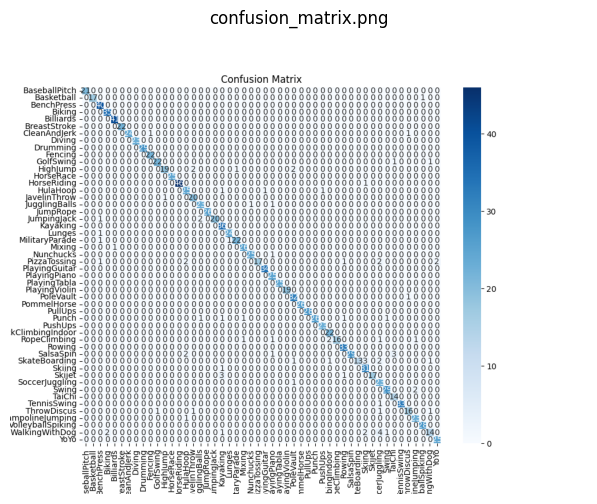

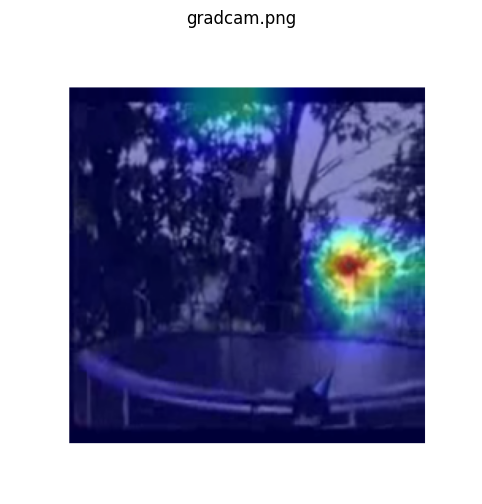

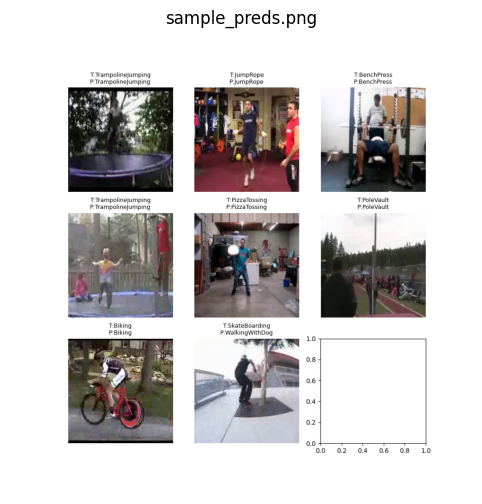

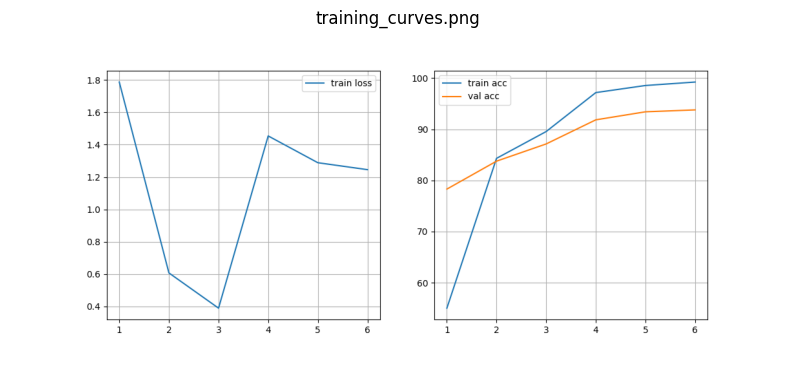

In [20]:
import matplotlib.pyplot as plt
import os
from PIL import Image

ckpt_dir = './checkpoints'

png_files = [
    'confusion_matrix.png',
    'gradcam.png',
    'sample_preds.png',
    'training_curves.png'
]

for fname in png_files:
    path = os.path.join(ckpt_dir, fname)
    if os.path.exists(path):
        img = Image.open(path)
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(fname)
        plt.show()
    else:
        print(f"{fname} not found in {ckpt_dir}")


## CODE

In [1]:
import os
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
import multiprocessing as mp

CONFIG = {
     'dataset_path': '/kaggle/input/realistic-action-recognition-ucf50/UCF50',
     'teacher_flow_dir': './teacher_flows',
     'img_size': 224,
     'num_frames': 16
}

def process_single_video(path):
    root = Path(CONFIG["dataset_path"])
    save_dir = CONFIG["teacher_flow_dir"]
    os.makedirs(save_dir, exist_ok=True)

    vid_id = path.stem
    last_file = os.path.join(save_dir, f"{vid_id}_{CONFIG['num_frames']-2}.npy")

    # skip already completed video
    if os.path.exists(last_file):
        return "skip"

    # read all frames
    cap = cv2.VideoCapture(str(path))
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (CONFIG["img_size"], CONFIG["img_size"]))
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
    cap.release()

    if len(frames) < 2:
        return "too_short"

    # uniform sampling
    idx = np.linspace(0, len(frames)-1, CONFIG["num_frames"]).astype(int)
    sampled = [frames[i] for i in idx]

    # flow generation
    for t in range(len(sampled) - 1):
        prev = sampled[t]
        curr = sampled[t + 1]

        flow = cv2.calcOpticalFlowFarneback(
            prev, curr, None,
            pyr_scale=0.5, levels=3, winsize=15,
            iterations=3, poly_n=5, poly_sigma=1.2, flags=0
        )

        save_path = os.path.join(save_dir, f"{vid_id}_{t}.npy")
        np.save(save_path, flow.astype(np.float16))

    return "ok"

def generate_teacher_flows_parallel():
    root = Path(CONFIG["dataset_path"])
    save_dir = CONFIG["teacher_flow_dir"]

    if not root.exists():
        print(f"ERROR: dataset path {root} does not exist.")
        return

    #find videos
    video_paths = list(root.glob("*/*.avi"))
    print(f"Found {len(video_paths)} videos.")

    #pool uses all CPU cores
    cpu_count = mp.cpu_count()
    print(f"Using {cpu_count} CPU cores...")

    with mp.Pool(cpu_count) as pool:
        results = list(tqdm(
            pool.imap(process_single_video, video_paths),
            total=len(video_paths),
            desc="Generating Flows (Parallel)"
        ))

    print("Summary:", {r: results.count(r) for r in set(results)})
    print(f"Flows saved to: {save_dir}")

generate_teacher_flows_parallel()

Found 6681 videos.
Using 4 CPU cores...


Generating Flows (Parallel): 100%|██████████| 6681/6681 [16:40<00:00,  6.68it/s]

Summary: {'ok': 6681}
Flows saved to: ./teacher_flows


Comparing Video: v_BenchPress_g07_c03
Video Path: /kaggle/input/realistic-action-recognition-ucf50/UCF50/BenchPress/v_BenchPress_g07_c03.avi


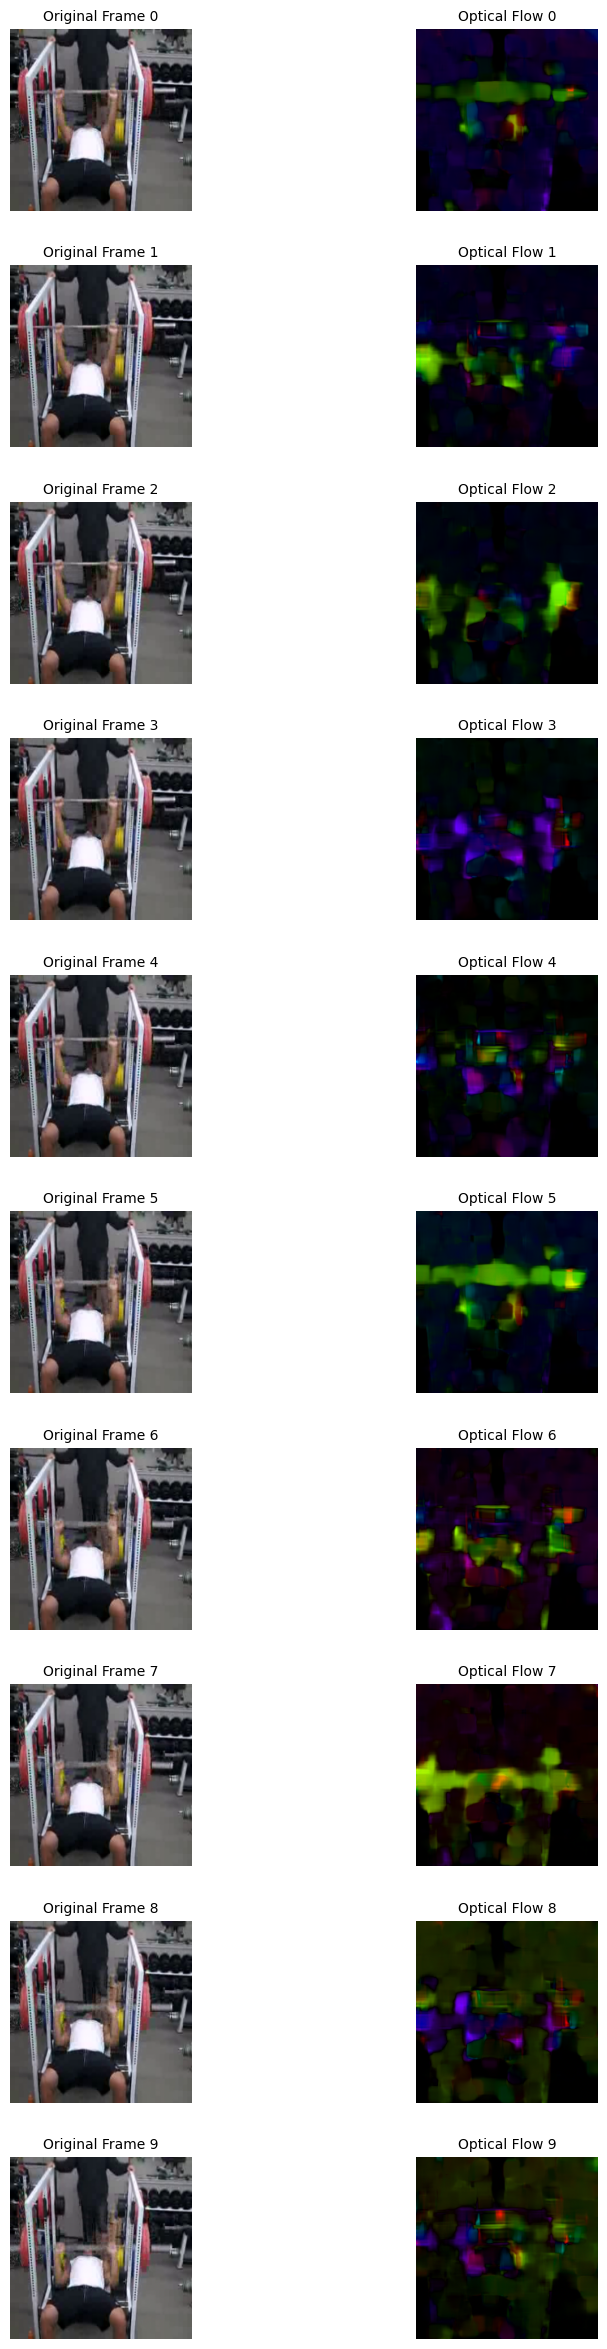

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path

# --- CONFIGURATION ---
# Path to your generated flows
FLOW_DIR = "/kaggle/working/teacher_flows" 
# Path to the original UCF50 dataset (Update this if different)
DATASET_ROOT = "/kaggle/input/realistic-action-recognition-ucf50/UCF50"

def flow_to_rgb(flow):
    """Converts (H, W, 2) flow to RGB image for visualization."""
    if flow is None: return np.zeros((224,224,3), dtype=np.uint8)
    h, w = flow.shape[:2]
    
    # Ensure float32 for OpenCV
    flow = flow.astype(np.float32)
    
    # Calculate magnitude and angle
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)
    
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    hsv[..., 0] = ang / 2        # Hue = direction
    hsv[..., 1] = 255            # Saturation = max
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX) # Value = speed
    
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def find_video_path(vid_id, root_dir):
    """
    Tries to find the video file for a given ID.
    UCF50 structure is usually: root/ClassName/v_ClassName_gXX_cXX.avi
    """
    # Extract ClassName from ID (e.g., v_Biking_g01_c01 -> Biking)
    # Strategy: Split by '_' and take the second element
    try:
        parts = vid_id.split('_')
        if len(parts) >= 2:
            class_name = parts[1]
            # specific fix for HandStandPushups or similar compound names if needed
            # But usually UCF matches folder names
            
            # Construct theoretical path
            vid_path = os.path.join(root_dir, class_name, f"{vid_id}.avi")
            if os.path.exists(vid_path):
                return vid_path
            
    except Exception as e:
        pass

    # Fallback: Brute force search (slow but reliable)
    print(f"Direct path failed, searching for {vid_id}.avi in {root_dir}...")
    for path in Path(root_dir).rglob(f"{vid_id}.avi"):
        return str(path)
        
    return None

def visualize_comparison(vid_id, flow_dir, dataset_root, num_frames=10):
    # 1. Find the Original Video
    vid_path = find_video_path(vid_id, dataset_root)
    
    if not vid_path:
        print(f"Could not find original video for ID: {vid_id}")
        return

    print(f"Comparing Video: {vid_id}")
    print(f"Video Path: {vid_path}")

    # 2. Setup Plot
    fig, axes = plt.subplots(num_frames, 2, figsize=(10, 3 * num_frames))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    
    # 3. Open Video
    cap = cv2.VideoCapture(vid_path)
    
    for t in range(num_frames):
        # --- Read Original Frame ---
        # We assume flow_0 corresponds to frame_0 -> frame_1 motion
        # So we display frame_0 as the "Source"
        cap.set(cv2.CAP_PROP_POS_FRAMES, t)
        ret, frame_bgr = cap.read()
        
        if ret:
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            frame_rgb = cv2.resize(frame_rgb, (224, 224)) # Resize to match flow
        else:
            frame_rgb = np.zeros((224, 224, 3), dtype=np.uint8)

        # --- Load Flow ---
        flow_path = os.path.join(flow_dir, f"{vid_id}_{t}.npy")
        if os.path.exists(flow_path):
            try:
                flow = np.load(flow_path)
                flow_rgb = flow_to_rgb(flow)
            except:
                flow_rgb = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            flow_rgb = np.zeros((224, 224, 3), dtype=np.uint8)

        # --- Plotting ---
        # Left Column: Original
        axes[t, 0].imshow(frame_rgb)
        axes[t, 0].set_title(f"Original Frame {t}", fontsize=10)
        axes[t, 0].axis('off')
        
        # Right Column: Optical Flow
        axes[t, 1].imshow(flow_rgb)
        axes[t, 1].set_title(f"Optical Flow {t}", fontsize=10)
        axes[t, 1].axis('off')

    cap.release()
    plt.show()

# --- MAIN EXECUTION ---
def run_random_comparison():
    if not os.path.exists(FLOW_DIR):
        print("Flow directory not found.")
        return

    # Pick random ID
    files = [f for f in os.listdir(FLOW_DIR) if f.endswith('.npy')]
    if not files:
        print("No flow files found.")
        return
        
    random_file = random.choice(files)
    vid_id = random_file.rsplit('_', 1)[0]
    
    visualize_comparison(vid_id, FLOW_DIR, DATASET_ROOT)

run_random_comparison()

Running on: cuda
Selected Video: v_PizzaTossing_g22_c04.avi


Downloading: "https://download.pytorch.org/models/raft_large_C_T_SKHT_V2-ff5fadd5.pth" to /root/.cache/torch/hub/checkpoints/raft_large_C_T_SKHT_V2-ff5fadd5.pth


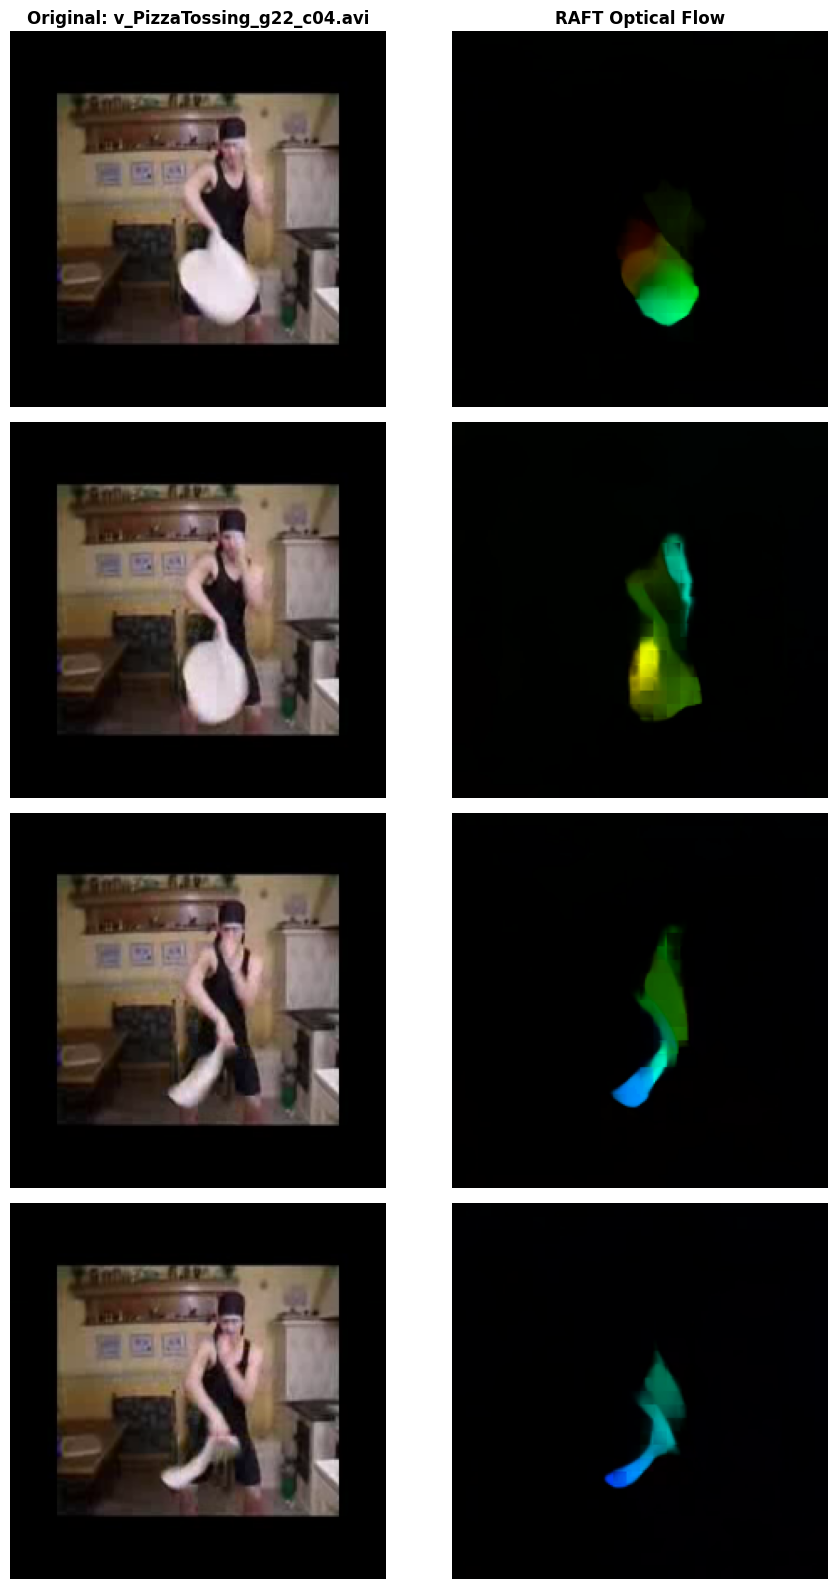

In [13]:
import cv2
import numpy as np
import torch
import torchvision.transforms.functional as F
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path

# --- CONFIGURATION ---
DATASET_ROOT = '/kaggle/input/realistic-action-recognition-ucf50/UCF50'
IMG_SIZE = 224
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Running on: {DEVICE}")

def load_raft():
    """Loads the pre-trained RAFT model from Torchvision."""
    weights = Raft_Large_Weights.DEFAULT
    model = raft_large(weights=weights, progress=False).to(DEVICE)
    model.eval()
    transforms = weights.transforms()
    return model, transforms

def flow_to_rgb(flow):
    """Converts flow (H, W, 2) to RGB image."""
    if flow is None: return np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
    
    # Ensure standard float32 for OpenCV
    flow = flow.astype(np.float32)
    
    # Cartesian to Polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)
    
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = ang / 2
    hsv[..., 1] = 255
    # Normalize magnitude to 0-255 for better visibility
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def compute_raft_flow(model, transforms, frame1, frame2):
    """Computes optical flow using RAFT."""
    # Resize to consistent size
    img1 = cv2.resize(frame1, (IMG_SIZE, IMG_SIZE))
    img2 = cv2.resize(frame2, (IMG_SIZE, IMG_SIZE))
    
    # Convert to Tensor (C, H, W) and Batch (1, C, H, W)
    img1_t = F.to_tensor(img1).unsqueeze(0).to(DEVICE)
    img2_t = F.to_tensor(img2).unsqueeze(0).to(DEVICE)
    
    # Preprocessing (Normalization specific to RAFT)
    img1_t, img2_t = transforms(img1_t, img2_t)

    with torch.no_grad():
        # RAFT returns a list of flow predictions; the last one is the best
        list_of_flows = model(img1_t, img2_t)
        predicted_flow = list_of_flows[-1][0]
    
    # Convert (2, H, W) -> (H, W, 2) and move to CPU
    return predicted_flow.permute(1, 2, 0).cpu().numpy()

def visualize_single_video_raft(num_frames_to_show=4):
    # 1. Find a random video
    all_vids = list(Path(DATASET_ROOT).rglob("*.avi"))
    if not all_vids:
        print("No videos found. Check your DATASET_ROOT path.")
        return

    vid_path = str(random.choice(all_vids))
    vid_name = os.path.basename(vid_path)
    print(f"Selected Video: {vid_name}")
    
    # 2. Load Model
    model, transforms = load_raft()
    
    # 3. Read Frames
    cap = cv2.VideoCapture(vid_path)
    frames = []
    while len(frames) < num_frames_to_show + 1:
        ret, frame = cap.read()
        if not ret: break
        # Convert BGR (OpenCV) to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    
    if len(frames) < 2:
        print("Video is too short.")
        return

    # 4. Compute and Plot
    fig, axes = plt.subplots(num_frames_to_show, 2, figsize=(10, 4 * num_frames_to_show))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    
    # Set headers
    axes[0, 0].set_title(f"Original: {vid_name}", fontsize=12, fontweight='bold')
    axes[0, 1].set_title("RAFT Optical Flow", fontsize=12, fontweight='bold')

    for i in range(num_frames_to_show):
        if i >= len(frames) - 1: break
        
        prev = frames[i]
        curr = frames[i+1]
        
        # Compute Flow
        flow = compute_raft_flow(model, transforms, prev, curr)
        flow_vis = flow_to_rgb(flow)
        
        # Resize original for display consistency
        prev_disp = cv2.resize(prev, (IMG_SIZE, IMG_SIZE))
        
        # Plot Original
        axes[i, 0].imshow(prev_disp)
        axes[i, 0].axis('off')
        
        # Plot RAFT
        axes[i, 1].imshow(flow_vis)
        axes[i, 1].axis('off')
        
    plt.tight_layout()
    plt.show()

# Run it
visualize_single_video_raft()

In [26]:
# config
import os
import shutil
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.amp import GradScaler, autocast
import torchvision.transforms as transforms
import torchvision.models as models
from einops import rearrange

# --- CONFIGURATION ---
CONFIG = {
    'dataset_path': '/kaggle/input/realistic-action-recognition-ucf50/UCF50',
    'save_dir': './checkpoints',
    
    # MATCHING YOUR SCRIPT:
    'teacher_flow_dir': './teacher_flows', 
    'precompute_teacher': False, 

    'num_frames': 16,        
    'frames_to_select': 8,   
    'img_size': 224,
    'num_classes': 50,

    # 2x T4 GPU Settings
    'batch_size': 16,        
    'accumulation_steps': 1, 
    'lr': 1e-4,
    'weight_decay': 1e-2,
    'num_workers': 4,

    'epochs_mhn_pretrain': 3,
    'epochs_classifier': 6,
    'epochs_finetune': 6,

    'use_teacher_distill': True,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42,
    'max_samples': None, 
    
    'lambda_grad': 0.5,
    'beta_flow': 0.5,
    'alpha_sparsity': 0.01,
}

# UTILS
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def flow_to_rgb(flow_tensor):
    if torch.is_tensor(flow_tensor):
        flow = flow_tensor.detach().cpu().numpy()
    else:
        flow = flow_tensor
    flow = np.transpose(flow, (1, 2, 0)) 
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    hsv[..., 1] = 255 
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# loss functions
def flow_epe_loss(pred, target):
    return torch.norm(pred - target, dim=1).mean()

def flow_grad_loss(pred, target):
    def gradient(x):
        dx = x[:, :, :, 1:] - x[:, :, :, :-1]
        dy = x[:, :, 1:, :] - x[:, :, :-1, :]
        return dx, dy
    pdx, pdy = gradient(pred)
    tdx, tdy = gradient(target)
    return (pdx - tdx).abs().mean() + (pdy - tdy).abs().mean()

def entropy_sparsity_loss(masks):
    eps = 1e-8
    entropy = -torch.sum(masks * torch.log(masks + eps), dim=-1)
    return entropy.mean()

def gumbel_softmax_sample(logits, tau=1.0):
    u = torch.rand_like(logits)
    g = -torch.log(-torch.log(u + 1e-20) + 1e-20)
    return F.softmax((logits + g) / tau, dim=-1)

In [27]:
# model definitoions
class MotionHallucinationNet(nn.Module):
    def __init__(self, in_ch=6, base_ch=32):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base_ch, 3, 1, 1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True))
        self.pool = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(nn.Conv2d(base_ch, base_ch*2, 3, 1, dilation=2, padding=2), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True))
        self.enc3 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch*4, 3, 1, dilation=4, padding=4), nn.BatchNorm2d(base_ch*4), nn.ReLU(inplace=True))
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = nn.Sequential(nn.Conv2d(base_ch*6, base_ch*2, 3, 1, 1), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True))
        self.dec1 = nn.Sequential(nn.Conv2d(base_ch*3, base_ch, 3, 1, 1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(base_ch, 2, 3, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool(e1)
        e2 = self.enc2(p1); p2 = self.pool(e2)
        e3 = self.enc3(p2)
        d2 = self.dec2(torch.cat([self.up(e3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1))
        return self.final(d1)

class DiffNet_Selector(nn.Module):
    def __init__(self, frames_to_select, use_gumbel=False):
        super().__init__()
        self.K = frames_to_select
        self.use_gumbel = use_gumbel
        mobilenet = models.mobilenet_v2(weights='DEFAULT')
        self.diff_encoder = nn.Sequential(*list(mobilenet.features.children())[:7])
        with torch.no_grad():
            dummy = torch.randn(1,3,CONFIG['img_size'],CONFIG['img_size'])
            feat_ch = self.diff_encoder(dummy).shape[1]
        self.saliency_head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(feat_ch, 1))

    def forward(self, frames, tau=1.0):
        B, T = frames.shape[:2]
        diffs = frames[:,1:] - frames[:,:-1]
        feats = self.diff_encoder(rearrange(diffs, 'b t c h w -> (b t) c h w'))
        logits = self.saliency_head(feats).view(B, T-1)
        logits = torch.cat([logits, torch.zeros(B,1, device=frames.device)], dim=1) 
        
        if self.training:
            if self.use_gumbel:
                masks = torch.stack([gumbel_softmax_sample(logits, tau) for _ in range(self.K)], dim=1)
            else:
                masks = F.softmax(logits, dim=1).unsqueeze(1).repeat(1, self.K, 1)
            return masks, logits
        else:
            _, indices = torch.topk(logits, self.K, dim=1)
            return torch.sort(indices, dim=1)[0], logits

class DS_STT_AFO(nn.Module):
    def __init__(self, num_classes, frames_to_select, use_gumbel=False):
        super().__init__()
        self.selector = DiffNet_Selector(frames_to_select, use_gumbel)
        self.mhn = MotionHallucinationNet()
        
        res_rgb = models.resnet34(weights='DEFAULT')
        res_flow = models.resnet34(weights='DEFAULT')
        self.rgb_enc = nn.Sequential(*list(res_rgb.children())[:-2])
        self.flow_enc = nn.Sequential(*list(res_flow.children())[:-2])
        
        with torch.no_grad():
            w = self.flow_enc[0].weight.mean(1, keepdim=True).repeat(1,2,1,1)
            self.flow_enc[0] = nn.Conv2d(2,64,7,2,3,bias=False)
            try: self.flow_enc[0].weight.copy_(w)
            except: nn.init.kaiming_normal_(self.flow_enc[0].weight)

        self.dim = 512
        self.rgb_proj = nn.Linear(512, self.dim)
        self.flow_proj = nn.Linear(512, self.dim)
        self.cross_attn = nn.MultiheadAttention(self.dim, 8, batch_first=True)
        self.flow_gate = nn.Parameter(torch.zeros(1))
        enc = nn.TransformerEncoderLayer(self.dim, 8, 2048, 0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(enc, 4)
        self.pos_embed = nn.Parameter(torch.randn(1, frames_to_select, self.dim) * 0.02)
        self.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(self.dim, num_classes))

    def forward(self, x, tau=1.0, return_meta=False):
        B, T, C, H, W = x.shape
        sel_out, sel_logits = self.selector(x, tau)

        if self.training:
            # Soft selection
            rgb_k = torch.einsum('btchw,bkt->bkchw', x, sel_out)
            x_next = torch.cat([x[:,1:], x[:,-1:]], dim=1)
            rgb_k_next = torch.einsum('btchw,bkt->bkchw', x_next, sel_out)
        else:
            # hard selection
            idx = sel_out
            batch_idx = torch.arange(B, device=x.device).unsqueeze(1)
            rgb_k = x[batch_idx, idx]
            rgb_k_next = x[batch_idx, torch.clamp(idx+1, max=T-1)]

        pairs = rearrange(torch.cat([rgb_k, rgb_k_next], dim=2), 'b k c h w -> (b k) c h w')
        pred_flow = self.mhn(pairs)

        rgb_in = rearrange(rgb_k, 'b k c h w -> (b k) c h w')
        rgb_feat = self.rgb_proj(F.adaptive_avg_pool2d(self.rgb_enc(rgb_in), (1,1)).flatten(1)).view(B, -1, self.dim)
        
        norm_flow = pred_flow / max(H, W)
        flow_feat = self.flow_proj(F.adaptive_avg_pool2d(self.flow_enc(norm_flow), (1,1)).flatten(1)).view(B, -1, self.dim)

        attn_out = self.cross_attn(rgb_feat, flow_feat, flow_feat)[0]
        fused = rgb_feat + self.flow_gate * attn_out + self.pos_embed
        logits = self.classifier(self.transformer(fused).mean(1))

        if return_meta:
            return logits, {'pred_flow': pred_flow.view(B, -1, 2, H, W), 'sel_logits': sel_logits, 'sel_out': sel_out}
        return logits

In [28]:
# dataset
class HARDataset(Dataset):
    def __init__(self, root, num_frames, transform=None, max_samples=None):
        self.root = Path(root)
        self.num_frames = num_frames
        self.transform = transform
        self.samples = []
        if self.root.exists():
            classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
            self.cls_map = {c:i for i,c in enumerate(classes)}
            for c in classes:
                for v in (self.root/c).glob('*.avi'):
                    self.samples.append((str(v), self.cls_map[c], v.stem))
        if max_samples: self.samples = self.samples[:max_samples]

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, label, vid_id = self.samples[idx]
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, f = cap.read()
            if not ret: break
            frames.append(Image.fromarray(cv2.cvtColor(f, cv2.COLOR_BGR2RGB)))
        cap.release()
        if not frames:
            frames = [Image.new('RGB', (CONFIG['img_size'], CONFIG['img_size'])) for _ in range(self.num_frames)]
        indices = np.linspace(0, len(frames)-1, self.num_frames).astype(int)
        frames = [frames[i] for i in indices]
        if self.transform:
            frames = [self.transform(f) for f in frames]
        return torch.stack(frames), label, vid_id

# load farneback npy files
def load_soft_teacher_flow_ram_safe(vid_ids, sel_masks, device):
    B, K, T = sel_masks.shape 
    H, W = CONFIG['img_size'], CONFIG['img_size']
    batch = []
    
    for b, vid in enumerate(vid_ids):
        flows = []
        #T-1 because we have 15 flows for 16 frames
        for t in range(T-1):
            p = f"{CONFIG['teacher_flow_dir']}/{vid}_{t}.npy"
            if os.path.exists(p):
                #load OpenCV style (H, W, 2)
                f_np = np.load(p).astype(np.float32)
                
                #convert to Torch (2, H, W)
                f_t = torch.from_numpy(f_np).permute(2,0,1)
                
                # resize if needed bec pytorch expects 4D for interpolate woo!!
                if f_t.shape[-1] != W:
                    f = F.interpolate(f_t.unsqueeze(0), size=(H,W), mode='bilinear', align_corners=False).squeeze(0)
                else:
                    f = f_t
            else:
                f = torch.zeros((2,H,W), dtype=torch.float32)
            flows.append(f)
            
        if not flows: 
            vid_stack = torch.zeros((T-1,2,H,W))
        else: 
            vid_stack = torch.stack(flows) # (15, 2, H, W)
        
        vid_stack = vid_stack.to(device)
        weights = sel_masks[b, :, :-1].to(device).float()
        denom = weights.sum(dim=1, keepdim=True) + 1e-8
        
        # weighted sum: (K, 15) * (15, 2, H, W) -> (K, 2, H, W)
        weighted = torch.einsum('kt, tchw -> kchw', weights/denom, vid_stack)
        batch.append(weighted)
        
    return torch.stack(batch)

In [29]:
# training engine
def train_one_epoch(model, loader, optimizer, scaler, criterion, device, stage):
    model.train()
    total_loss = 0.0; correct = 0; total = 0
    
    for i, (frames, labels, vid_ids) in enumerate(tqdm(loader, desc=f"Train {stage}")):
        frames, labels = frames.to(device), labels.to(device)
        
        with autocast(device_type='cuda' if device == 'cuda' else 'cpu'):
            logits, meta = model(frames, return_meta=True)
            ce = criterion(logits, labels)
            sparsity = entropy_sparsity_loss(meta['sel_out'])
            
            flow_loss = torch.tensor(0., device=device)
            if stage == 'C' and CONFIG['use_teacher_distill']:
                # Load ground truth flows on demand
                teacher = load_soft_teacher_flow_ram_safe(vid_ids, meta['sel_out'], device)
                pred = meta['pred_flow']
                flow_loss = flow_epe_loss(pred, teacher) + CONFIG['lambda_grad'] * flow_grad_loss(pred, teacher)
                
            loss = (ce + CONFIG['alpha_sparsity']*sparsity + CONFIG['beta_flow']*flow_loss) / CONFIG['accumulation_steps']
            
        scaler.scale(loss).backward()
        if (i + 1) % CONFIG['accumulation_steps'] == 0:
            scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
            
        total_loss += loss.item() * CONFIG['accumulation_steps']
        correct += (logits.argmax(1) == labels).sum().item(); total += labels.size(0)

    return total_loss/len(loader), 100.*correct/total

def validate_with_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0; correct = 0; total = 0
    with torch.no_grad():
        for frames, labels, _ in tqdm(loader, desc="Validating"):
            frames, labels = frames.to(device), labels.to(device)
            logits = model(frames)
            loss = criterion(logits, labels)
            total_loss += loss.item() * frames.size(0)
            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / total if total > 0 else 0.0
    acc = 100. * correct / total if total > 0 else 0.0
    print(f"[Val] Loss: {avg_loss:.4f} | Acc: {acc:.2f}%")
    return avg_loss, acc

def run_training_pipeline_full():
    set_seed(CONFIG['seed'])
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    device = CONFIG['device']

    # dataset transforms
    tfm = transforms.Compose([
        transforms.Resize((240,240)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2,0.2,0.2,0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    ds = HARDataset(CONFIG['dataset_path'], CONFIG['num_frames'], tfm, CONFIG['max_samples'])
    train_sz = int(0.8 * len(ds))
    train_ds, val_ds = random_split(ds, [train_sz, len(ds)-train_sz])
    train_dl = DataLoader(train_ds, CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'])
    val_dl = DataLoader(val_ds, CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])

    base_model = DS_STT_AFO(len(ds.cls_map), CONFIG['frames_to_select']).to(device)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(base_model)
    else:
        print("Using single GPU")
        model = base_model

    scaler = GradScaler('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    best_val = -1.0

    # Stage A: MHN Pretrain
    print("\n=== Stage A: MHN Pretrain ===")
    opt_mhn = optim.AdamW(base_model.mhn.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    
    for ep in range(CONFIG['epochs_mhn_pretrain']):
        base_model.mhn.train()
        total_mhn_loss = 0
        for frames, _, vid_ids in tqdm(train_dl, desc=f"MHN Epoch {ep+1}"):
            frames = frames.to(device)
            t = random.randint(0, CONFIG['num_frames']-2)
            pair = torch.cat([frames[:,t], frames[:,t+1]], dim=1)
            
            with autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                pred = base_model.mhn(pair) 
                
                # load ground truth specific to 't'
                targets = []
                for vid in vid_ids:
                    p = f"{CONFIG['teacher_flow_dir']}/{vid}_{t}.npy"
                    try:
                        # Load (H,W,2) -> Permute (2,H,W)
                        f_np = np.load(p).astype(np.float32)
                        f_t = torch.from_numpy(f_np).permute(2,0,1).float()
                        
                        if f_t.shape[-1] != CONFIG['img_size']:
                             f_t = F.interpolate(f_t.unsqueeze(0), size=(CONFIG['img_size'], CONFIG['img_size']), mode='bilinear', align_corners=False).squeeze(0)
                        targets.append(f_t)
                    except:
                        targets.append(torch.zeros((2, CONFIG['img_size'], CONFIG['img_size'])))
                
                target_batch = torch.stack(targets).to(device)
                loss = flow_epe_loss(pred, target_batch)
            
            scaler.scale(loss).backward()
            scaler.step(opt_mhn); scaler.update(); opt_mhn.zero_grad()
            total_mhn_loss += loss.item()
        print(f"MHN Loss: {total_mhn_loss/len(train_dl):.4f}")

    #Stage B: Warmup
    print("\n=== Stage B: Warmup ===")
    for p in base_model.mhn.parameters(): p.requires_grad = False
    opt = optim.AdamW([p for p in base_model.parameters() if p.requires_grad], lr=CONFIG['lr'])
    
    for ep in range(CONFIG['epochs_classifier']):
        tl, ta = train_one_epoch(model, train_dl, opt, scaler, criterion, device, 'B')
        vl, va = validate_with_loss(model, val_dl, criterion, device)
        history['train_loss'].append(tl); history['val_loss'].append(vl)
        history['train_acc'].append(ta); history['val_acc'].append(va)
        if va > best_val: best_val = va; torch.save(base_model.state_dict(), f"{CONFIG['save_dir']}/best.pth")

    # Stage C: Finetune
    print("\n=== Stage C: Finetune ===")
    for p in base_model.mhn.parameters(): p.requires_grad = True
    opt = optim.AdamW(base_model.parameters(), lr=CONFIG['lr']*0.1)
    
    for ep in range(CONFIG['epochs_finetune']):
        tl, ta = train_one_epoch(model, train_dl, opt, scaler, criterion, device, 'C')
        vl, va = validate_with_loss(model, val_dl, criterion, device)
        history['train_loss'].append(tl); history['val_loss'].append(vl)
        history['train_acc'].append(ta); history['val_acc'].append(va)
        if va > best_val: best_val = va; torch.save(base_model.state_dict(), f"{CONFIG['save_dir']}/best.pth")
        
    return model, val_dl, history

In [35]:
# visualization

def visualize_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train', marker='o')
    plt.plot(epochs, history['val_loss'], label='Val', marker='o')
    plt.title('Loss'); plt.legend(); plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train', marker='o')
    plt.plot(epochs, history['val_acc'], label='Val', marker='o')
    plt.title('Accuracy'); plt.legend(); plt.grid(True)
    plt.tight_layout(); 
    plt.show()
    plt.savefig("training_curves.png")

def visualize_5_hallucinations(model, dataloader, device):
    model.eval()
    count = 0; max_count = 5
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(10, 15))
    with torch.no_grad():
        for frames, _, _ in dataloader:
            frames = frames.to(device)
            # Use DataParallel model
            _, meta = model(frames, return_meta=True)
            
            pred_flows = meta['pred_flow']
            sel_out = meta['sel_out']
            
            for b in range(frames.shape[0]):
                if count >= max_count: break
                idx_t = sel_out[b, 0].item() 
                rgb = frames[b, idx_t].permute(1,2,0).cpu().numpy()
                rgb = std * rgb + mean; rgb = np.clip(rgb, 0, 1)
                
                flow_tensor = pred_flows[b, 0] 
                rgb_flow = flow_to_rgb(flow_tensor)
                
                plt.subplot(5, 2, count*2 + 1)
                plt.imshow(rgb); plt.title(f"Sample {count+1}: Selected"); plt.axis('off')
                plt.subplot(5, 2, count*2 + 2)
                plt.imshow(rgb_flow); plt.title(f"Sample {count+1}: Hallucinated Flow"); plt.axis('off')
                count += 1
            if count >= max_count: break
    plt.tight_layout(); 
    plt.show()

Using 2 GPUs!

=== Stage A: MHN Pretrain ===


MHN Epoch 1: 100%|██████████| 334/334 [09:04<00:00,  1.63s/it]


MHN Loss: 3.6705


MHN Epoch 2: 100%|██████████| 334/334 [09:05<00:00,  1.63s/it]


MHN Loss: 3.6598


MHN Epoch 3: 100%|██████████| 334/334 [09:08<00:00,  1.64s/it]


MHN Loss: 3.6718

=== Stage B: Warmup ===


Validating: 100%|██████████| 84/84 [02:35<00:00,  1.86s/it]


[Val] Loss: 2.0229 | Acc: 56.62%


Validating: 100%|██████████| 84/84 [02:34<00:00,  1.84s/it]


[Val] Loss: 1.4301 | Acc: 75.32%


Validating: 100%|██████████| 84/84 [02:30<00:00,  1.79s/it]


[Val] Loss: 1.2844 | Acc: 81.38%


Validating: 100%|██████████| 84/84 [02:28<00:00,  1.77s/it]


[Val] Loss: 1.1133 | Acc: 88.03%


Validating: 100%|██████████| 84/84 [02:33<00:00,  1.82s/it]


[Val] Loss: 1.1422 | Acc: 85.94%


Validating: 100%|██████████| 84/84 [02:31<00:00,  1.80s/it]


[Val] Loss: 1.0334 | Acc: 90.28%

=== Stage C: Finetune ===


Validating: 100%|██████████| 84/84 [02:29<00:00,  1.78s/it]


[Val] Loss: 0.9002 | Acc: 95.81%


Validating: 100%|██████████| 84/84 [02:35<00:00,  1.85s/it]


[Val] Loss: 0.8846 | Acc: 96.34%


Validating: 100%|██████████| 84/84 [02:33<00:00,  1.83s/it]


[Val] Loss: 0.8782 | Acc: 96.04%


Validating: 100%|██████████| 84/84 [02:32<00:00,  1.81s/it]


[Val] Loss: 0.8687 | Acc: 95.96%


Validating: 100%|██████████| 84/84 [02:35<00:00,  1.85s/it]


[Val] Loss: 0.8820 | Acc: 95.59%


Validating: 100%|██████████| 84/84 [02:36<00:00,  1.86s/it]


[Val] Loss: 0.8966 | Acc: 94.91%


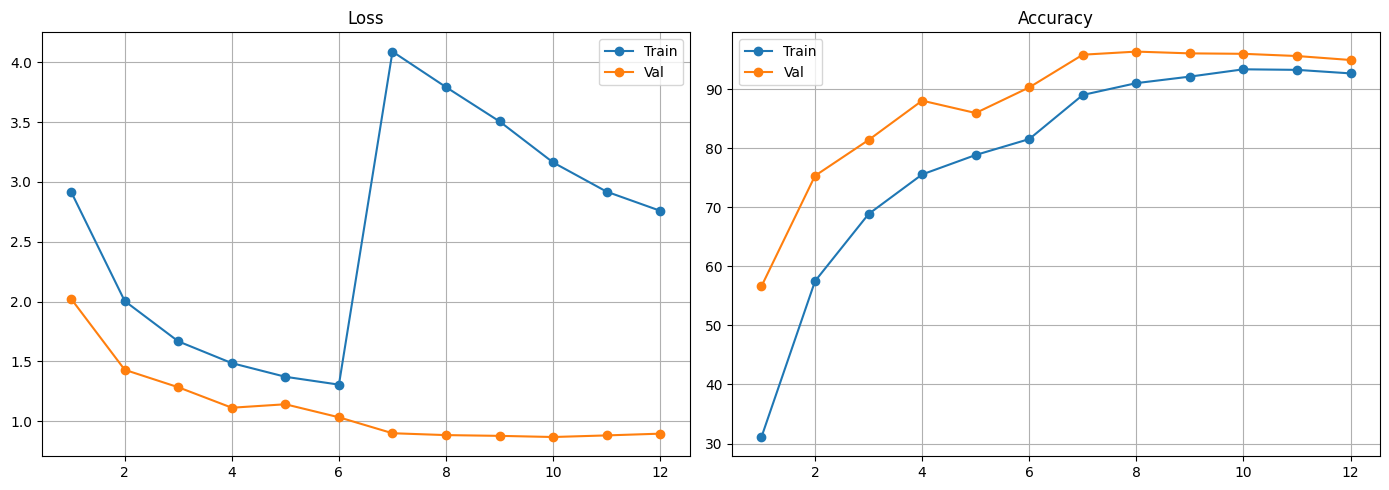

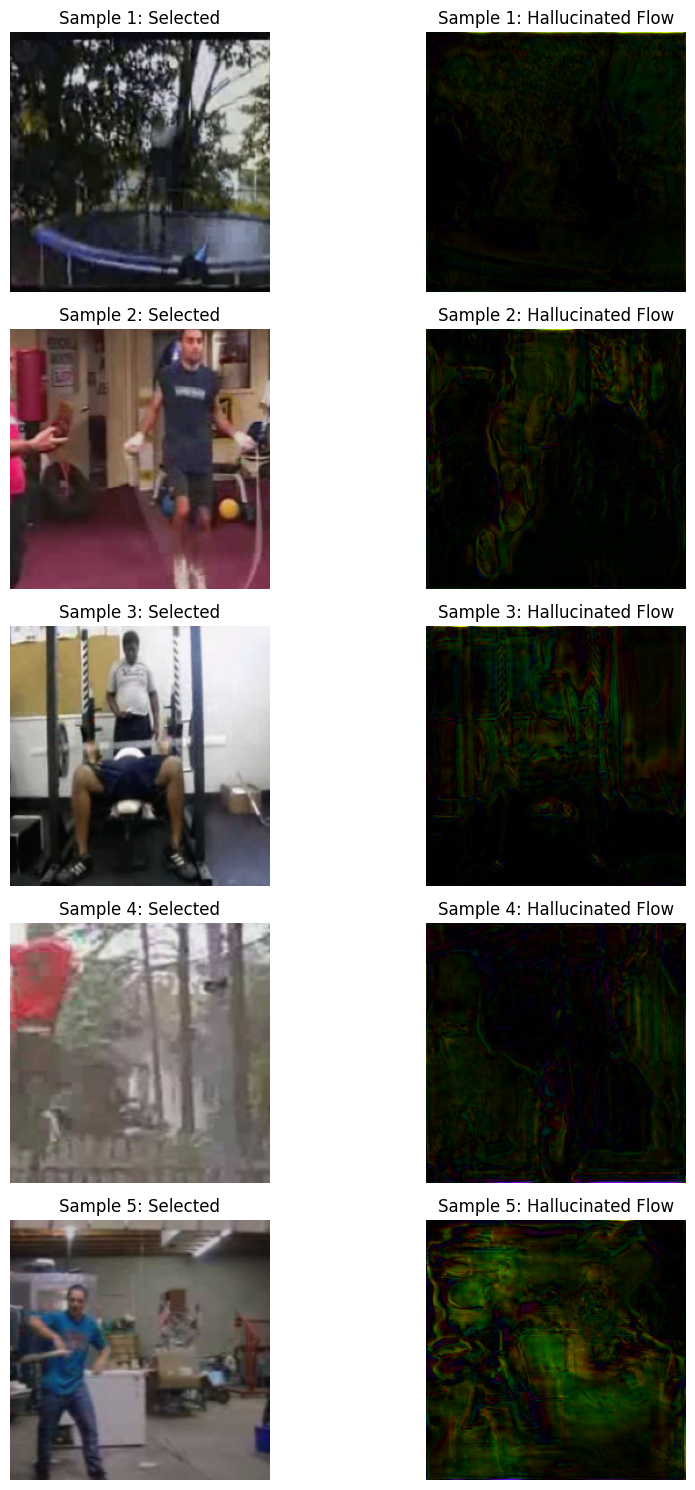

In [31]:
# running everything
if __name__ == "__main__":
    trained_model, val_loader, history_data = run_training_pipeline_full()

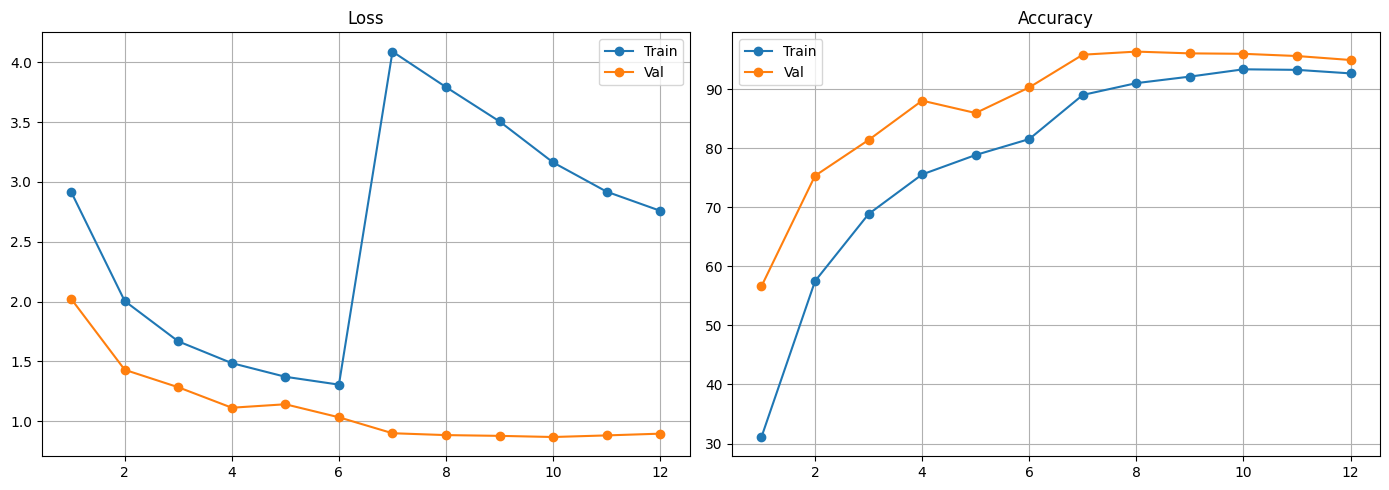

<Figure size 640x480 with 0 Axes>

In [36]:
visualize_training_curves(history_data)

## RAFT

In [2]:
!pip install decord --quiet
print("Decord installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 91.3 MB/s eta 0:00:00:00:0100:01
Decord installed.


In [42]:
# %%
# 1. IMPORTS & CONFIGURATION
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.amp import GradScaler, autocast
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights 
from einops import rearrange

# Import Decord for fast video loading
try:
    from decord import VideoReader, cpu
except ImportError:
    print("Decord not found. Please run Cell 0.")

CONFIG = {
    'dataset_path': '/kaggle/input/realistic-action-recognition-ucf50/UCF50',
    'save_dir': './checkpoints',
    'teacher_flow_dir': None, # On-the-fly
    
    'num_frames': 16,        
    'frames_to_select': 8,   
    'img_size': 224,
    'num_classes': 50,

    # GPU SETTINGS
    'batch_size': 32,        
    'accumulation_steps': 1, 
    'lr': 1e-4,
    'weight_decay': 1e-2,
    'num_workers': 4,

    # EPOCHS
    'epochs_mhn_pretrain': 6,
    'epochs_classifier': 6,
    'epochs_finetune': 6,

    'use_teacher_distill': True,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42,
    'max_samples': None, 
    
    # LOSS WEIGHTS
    'lambda_grad': 0.5,
    'beta_flow': 0.5,
    'alpha_sparsity': 0.01,
}

# --- CUSTOM SHARPENING TRANSFORM ---
class UnsharpMask(object):
    """Sharpen image to help RAFT and Student Model see edges better."""
    def __init__(self, kernel_size=(5, 5), sigma=1.0, amount=1.5, threshold=0):
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.amount = amount
        self.threshold = threshold

    def __call__(self, img):
        img_np = np.array(img)
        blurred = cv2.GaussianBlur(img_np, self.kernel_size, self.sigma)
        sharpened = float(self.amount + 1) * img_np - float(self.amount) * blurred
        sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
        return Image.fromarray(sharpened)

# --- UTILITIES ---
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def flow_to_rgb(flow_tensor):
    """Visualizes flow (2, H, W) -> RGB Image"""
    if torch.is_tensor(flow_tensor):
        flow = flow_tensor.detach().cpu().numpy()
    else:
        flow = flow_tensor
    flow = np.transpose(flow, (1, 2, 0)) 
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    hsv[..., 1] = 255 
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# --- LOSSES ---
def flow_epe_loss(pred, target):
    return torch.norm(pred - target, dim=1).mean()

def flow_grad_loss(pred, target):
    def gradient(x):
        dx = x[:, :, :, 1:] - x[:, :, :, :-1]
        dy = x[:, :, 1:, :] - x[:, :, :-1, :]
        return dx, dy
    pdx, pdy = gradient(pred)
    tdx, tdy = gradient(target)
    return (pdx - tdx).abs().mean() + (pdy - tdy).abs().mean()

def entropy_sparsity_loss(masks):
    eps = 1e-8
    entropy = -torch.sum(masks * torch.log(masks + eps), dim=-1)
    return entropy.mean()

def gumbel_softmax_sample(logits, tau=1.0):
    u = torch.rand_like(logits)
    g = -torch.log(-torch.log(u + 1e-20) + 1e-20)
    return F.softmax((logits + g) / tau, dim=-1)

In [43]:
# %%
# 2. RAFT TEACHER MODULE (FIXED SCALING & BUFFERS)

class RAFT_Teacher(nn.Module):
    def __init__(self, device):
        super().__init__()
        print("Loading RAFT Teacher (Torchvision)...")
        self.weights = Raft_Large_Weights.C_T_SKHT_V2 
        self.model = raft_large(weights=self.weights, progress=False).to(device)
        self.model.eval()
        self.transforms = self.weights.transforms()
        
        # Buffers to undo ImageNet normalization
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1))

    @torch.no_grad()
    def forward(self, img1, img2):
        # 1. Un-normalize to [0, 1]
        img1_raw = img1 * self.std + self.mean
        img2_raw = img2 * self.std + self.mean
        
        # 2. CRITICAL FIX: Scale to [0, 255] for RAFT
        img1_raw = img1_raw * 255.0
        img2_raw = img2_raw * 255.0
        
        # 3. Apply RAFT Transforms
        img1_t, img2_t = self.transforms(img1_raw, img2_raw)
        
        # 4. Inference
        list_of_flows = self.model(img1_t, img2_t)
        predicted_flow = list_of_flows[-1] 
        
        # 5. Resize back
        if predicted_flow.shape[-1] != img1.shape[-1]:
             predicted_flow = F.interpolate(predicted_flow, size=img1.shape[-2:], mode='bilinear', align_corners=False)
             
        return predicted_flow

In [44]:
# %%
# 3. STUDENT MODEL DEFINITIONS

class MotionHallucinationNet(nn.Module):
    def __init__(self, in_ch=6, base_ch=32):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base_ch, 3, 1, 1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True))
        self.pool = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(nn.Conv2d(base_ch, base_ch*2, 3, 1, dilation=2, padding=2), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True))
        self.enc3 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch*4, 3, 1, dilation=4, padding=4), nn.BatchNorm2d(base_ch*4), nn.ReLU(inplace=True))
        
        # FIX: Use 'bicubic' for sharper flow upsampling
        self.up = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=True)
        
        self.dec2 = nn.Sequential(nn.Conv2d(base_ch*6, base_ch*2, 3, 1, 1), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True))
        self.dec1 = nn.Sequential(nn.Conv2d(base_ch*3, base_ch, 3, 1, 1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(base_ch, 2, 3, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool(e1)
        e2 = self.enc2(p1); p2 = self.pool(e2)
        e3 = self.enc3(p2)
        d2 = self.dec2(torch.cat([self.up(e3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1))
        return self.final(d1)

class DiffNet_Selector(nn.Module):
    def __init__(self, frames_to_select, use_gumbel=False):
        super().__init__()
        self.K = frames_to_select
        self.use_gumbel = use_gumbel
        mobilenet = models.mobilenet_v2(weights='DEFAULT')
        self.diff_encoder = nn.Sequential(*list(mobilenet.features.children())[:7])
        with torch.no_grad():
            dummy = torch.randn(1,3,CONFIG['img_size'],CONFIG['img_size'])
            feat_ch = self.diff_encoder(dummy).shape[1]
        self.saliency_head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(feat_ch, 1))

    def forward(self, frames, tau=1.0):
        B, T = frames.shape[:2]
        diffs = frames[:,1:] - frames[:,:-1]
        feats = self.diff_encoder(rearrange(diffs, 'b t c h w -> (b t) c h w'))
        logits = self.saliency_head(feats).view(B, T-1)
        logits = torch.cat([logits, torch.zeros(B,1, device=frames.device)], dim=1) 
        
        if self.training:
            if self.use_gumbel:
                masks = torch.stack([gumbel_softmax_sample(logits, tau) for _ in range(self.K)], dim=1)
            else:
                masks = F.softmax(logits, dim=1).unsqueeze(1).repeat(1, self.K, 1)
            return masks, logits
        else:
            _, indices = torch.topk(logits, self.K, dim=1)
            return torch.sort(indices, dim=1)[0], logits

class DS_STT_AFO(nn.Module):
    def __init__(self, num_classes, frames_to_select, use_gumbel=False):
        super().__init__()
        self.selector = DiffNet_Selector(frames_to_select, use_gumbel)
        self.mhn = MotionHallucinationNet()
        
        res_rgb = models.resnet34(weights='DEFAULT')
        res_flow = models.resnet34(weights='DEFAULT')
        self.rgb_enc = nn.Sequential(*list(res_rgb.children())[:-2])
        self.flow_enc = nn.Sequential(*list(res_flow.children())[:-2])
        
        with torch.no_grad():
            w = self.flow_enc[0].weight.mean(1, keepdim=True).repeat(1,2,1,1)
            self.flow_enc[0] = nn.Conv2d(2,64,7,2,3,bias=False)
            try: self.flow_enc[0].weight.copy_(w)
            except: nn.init.kaiming_normal_(self.flow_enc[0].weight)

        self.dim = 512
        self.rgb_proj = nn.Linear(512, self.dim)
        self.flow_proj = nn.Linear(512, self.dim)
        self.cross_attn = nn.MultiheadAttention(self.dim, 8, batch_first=True)
        self.flow_gate = nn.Parameter(torch.zeros(1))
        enc = nn.TransformerEncoderLayer(self.dim, 8, 2048, 0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(enc, 4)
        self.pos_embed = nn.Parameter(torch.randn(1, frames_to_select, self.dim) * 0.02)
        self.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(self.dim, num_classes))

    def forward(self, x, tau=1.0, return_meta=False):
        B, T, C, H, W = x.shape
        sel_out, sel_logits = self.selector(x, tau)

        if self.training:
            rgb_k = torch.einsum('btchw,bkt->bkchw', x, sel_out)
            x_next = torch.cat([x[:,1:], x[:,-1:]], dim=1)
            rgb_k_next = torch.einsum('btchw,bkt->bkchw', x_next, sel_out)
        else:
            idx = sel_out
            batch_idx = torch.arange(B, device=x.device).unsqueeze(1)
            rgb_k = x[batch_idx, idx]
            rgb_k_next = x[batch_idx, torch.clamp(idx+1, max=T-1)]

        pairs = rearrange(torch.cat([rgb_k, rgb_k_next], dim=2), 'b k c h w -> (b k) c h w')
        pred_flow = self.mhn(pairs)

        rgb_in = rearrange(rgb_k, 'b k c h w -> (b k) c h w')
        rgb_feat = self.rgb_proj(F.adaptive_avg_pool2d(self.rgb_enc(rgb_in), (1,1)).flatten(1)).view(B, -1, self.dim)
        
        norm_flow = pred_flow / max(H, W)
        flow_feat = self.flow_proj(F.adaptive_avg_pool2d(self.flow_enc(norm_flow), (1,1)).flatten(1)).view(B, -1, self.dim)

        attn_out = self.cross_attn(rgb_feat, flow_feat, flow_feat)[0]
        fused = rgb_feat + self.flow_gate * attn_out + self.pos_embed
        logits = self.classifier(self.transformer(fused).mean(1))

        if return_meta:
            return logits, {'pred_flow': pred_flow.view(B, -1, 2, H, W), 'sel_logits': sel_logits, 'sel_out': sel_out}
        return logits

In [45]:
# %%
# 4. DATASET (FIXED ADJACENCY)

class FastHARDataset(Dataset):
    def __init__(self, root, num_frames, transform=None, max_samples=None, mode='full'):
        self.root = Path(root)
        self.num_frames = num_frames
        self.transform = transform
        self.mode = mode
        self.samples = []
        if self.root.exists():
            classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
            self.cls_map = {c:i for i,c in enumerate(classes)}
            for c in classes:
                for v in (self.root/c).glob('*.avi'):
                    self.samples.append((str(v), self.cls_map[c], v.stem))
        if max_samples: self.samples = self.samples[:max_samples]

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, label, vid_id = self.samples[idx]
        try:
            vr = VideoReader(path, ctx=cpu(0))
            total_frames = len(vr)
            
            # --- PRETRAIN MODE (FIXED) ---
            if self.mode == 'pretrain':
                if total_frames < 2: raise ValueError("Short video")
                
                # CRITICAL FIX: Pick EXACT neighbors (t, t+1)
                # Do NOT use linspace here.
                t = random.randint(0, total_frames - 2)
                
                # Get batch of 2 frames
                frames = vr.get_batch([t, t+1]).asnumpy()
                
                pair = [Image.fromarray(f) for f in frames]
                if self.transform: pair = [self.transform(img) for img in pair]
                return torch.cat(pair, dim=0), label
                
            # --- FULL MODE (Standard) ---
            else:
                indices = np.linspace(0, total_frames-1, self.num_frames).astype(int)
                frames = vr.get_batch(indices).asnumpy()
                frames_pil = [Image.fromarray(f) for f in frames]
                if self.transform: frames_pil = [self.transform(f) for f in frames_pil]
                return torch.stack(frames_pil), label, vid_id

        except Exception:
            # Fallback
            if self.mode == 'pretrain': return torch.zeros((6, CONFIG['img_size'], CONFIG['img_size'])), label
            else: return torch.zeros((self.num_frames, 3, CONFIG['img_size'], CONFIG['img_size'])), label, vid_id

In [46]:
# %%
# 5. TRAINING ENGINE

def train_one_epoch(model, teacher, loader, optimizer, scaler, criterion, device, stage):
    model.train()
    total_loss = 0.0; correct = 0; total = 0
    
    for i, (frames, labels, vid_ids) in enumerate(tqdm(loader, desc=f"Train {stage}")):
        frames, labels = frames.to(device), labels.to(device)
        
        with autocast(device_type='cuda'):
            logits, meta = model(frames, return_meta=True)
            ce = criterion(logits, labels)
            sparsity = entropy_sparsity_loss(meta['sel_out'])
            
            flow_loss = torch.tensor(0., device=device)
            if stage == 'C' and CONFIG['use_teacher_distill']:
                sel_out = meta['sel_out']
                B, K = sel_out.shape
                batch_indices = torch.arange(B, device=device).unsqueeze(1)
                
                # Gather frames
                rgb_curr = frames[batch_indices, sel_out]
                rgb_next = frames[batch_indices, torch.clamp(sel_out+1, max=CONFIG['num_frames']-1)]
                
                # Flatten
                flat_curr = rearrange(rgb_curr, 'b k c h w -> (b k) c h w')
                flat_next = rearrange(rgb_next, 'b k c h w -> (b k) c h w')
                
                with torch.no_grad():
                    teacher_flow_flat = teacher(flat_curr, flat_next)
                
                student_flow = meta['pred_flow']
                student_flow_flat = rearrange(student_flow, 'b k c h w -> (b k) c h w')
                
                flow_loss = flow_epe_loss(student_flow_flat, teacher_flow_flat) + \
                            CONFIG['lambda_grad'] * flow_grad_loss(student_flow_flat, teacher_flow_flat)
                
            loss = (ce + CONFIG['alpha_sparsity']*sparsity + CONFIG['beta_flow']*flow_loss) / CONFIG['accumulation_steps']
            
        scaler.scale(loss).backward()
        if (i + 1) % CONFIG['accumulation_steps'] == 0:
            scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
            
        total_loss += loss.item() * CONFIG['accumulation_steps']
        correct += (logits.argmax(1) == labels).sum().item(); total += labels.size(0)

    return total_loss/len(loader), 100.*correct/total

def run_training_pipeline_full():
    set_seed(CONFIG['seed'])
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    device = CONFIG['device']

    # 1. Setup Models
    base_model = DS_STT_AFO(len(os.listdir(CONFIG['dataset_path'])), CONFIG['frames_to_select']).to(device)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(base_model)
    else:
        print("Using Single GPU")
        model = base_model

    teacher = RAFT_Teacher(device)
    if torch.cuda.device_count() > 1:
        teacher = nn.DataParallel(teacher)

    # 2. Transforms (FIX: SHARPER INPUTS)
    tfm = transforms.Compose([
        # Don't zoom in. Resize larger, then crop.
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.RandomCrop(224),
        
        # KEY FIX: Sharpen the blurry video frames
        UnsharpMask(amount=1.5), 
        
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

    scaler = GradScaler('cuda')
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    best_val = -1.0

    # --- Stage A: MHN Pretrain ---
    print("\n=== Stage A: MHN Pretrain ===")
    ds_pre = FastHARDataset(CONFIG['dataset_path'], CONFIG['num_frames'], tfm, CONFIG['max_samples'], mode='pretrain')
    dl_pre = DataLoader(ds_pre, CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)
    
    opt_mhn = optim.AdamW(base_model.mhn.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    
    for ep in range(CONFIG['epochs_mhn_pretrain']):
        base_model.mhn.train()
        total_mhn_loss = 0
        for pair, _ in tqdm(dl_pre, desc=f"MHN Epoch {ep+1}"):
            pair = pair.to(device)
            curr = pair[:, :3]
            next_f = pair[:, 3:]
            
            with autocast('cuda'):
                pred = base_model.mhn(pair) 
                with torch.no_grad():
                    target = teacher(curr, next_f)
                loss = flow_epe_loss(pred, target)
            
            scaler.scale(loss).backward()
            scaler.step(opt_mhn); scaler.update(); opt_mhn.zero_grad()
            total_mhn_loss += loss.item()
        print(f"MHN Loss: {total_mhn_loss/len(dl_pre):.4f}")

    # --- Stage B/C Dataset ---
    ds = FastHARDataset(CONFIG['dataset_path'], CONFIG['num_frames'], tfm, CONFIG['max_samples'], mode='full')
    train_sz = int(0.8 * len(ds))
    train_ds, val_ds = random_split(ds, [train_sz, len(ds)-train_sz])
    train_dl = DataLoader(train_ds, CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)
    val_dl = DataLoader(val_ds, CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)

    # --- Stage B: Warmup ---
    print("\n=== Stage B: Warmup ===")
    for p in base_model.mhn.parameters(): p.requires_grad = False
    opt = optim.AdamW([p for p in base_model.parameters() if p.requires_grad], lr=CONFIG['lr'])
    
    for ep in range(CONFIG['epochs_classifier']):
        tl, ta = train_one_epoch(model, teacher, train_dl, opt, scaler, criterion, device, 'B')
        
        model.eval(); corr=0; tot=0; vl=0.0
        with torch.no_grad():
            for f, l, _ in val_dl:
                f, l = f.to(device), l.to(device)
                logits = model(f)
                loss = criterion(logits, l)
                vl += loss.item() * f.size(0)
                corr += (logits.argmax(1)==l).sum().item(); tot += l.size(0)
        va = 100.*corr/tot; vl = vl/tot
        print(f"Val Acc: {va:.2f}% | Val Loss: {vl:.4f}")
        
        history['train_loss'].append(tl); history['train_acc'].append(ta)
        history['val_loss'].append(vl);   history['val_acc'].append(va)
        if va > best_val: best_val = va; torch.save(base_model.state_dict(), f"{CONFIG['save_dir']}/best.pth")

    # --- Stage C: Finetune ---
    print("\n=== Stage C: Finetune ===")
    for p in base_model.mhn.parameters(): p.requires_grad = True
    opt = optim.AdamW(base_model.parameters(), lr=CONFIG['lr']*0.1)
    
    for ep in range(CONFIG['epochs_finetune']):
        tl, ta = train_one_epoch(model, teacher, train_dl, opt, scaler, criterion, device, 'C')
        
        model.eval(); corr=0; tot=0; vl=0.0
        with torch.no_grad():
            for f, l, _ in val_dl:
                f, l = f.to(device), l.to(device)
                logits = model(f)
                loss = criterion(logits, l)
                vl += loss.item() * f.size(0)
                corr += (logits.argmax(1)==l).sum().item(); tot += l.size(0)
        va = 100.*corr/tot; vl = vl/tot
        print(f"Val Acc: {va:.2f}% | Val Loss: {vl:.4f}")
        
        history['train_loss'].append(tl); history['train_acc'].append(ta)
        history['val_loss'].append(vl);   history['val_acc'].append(va)
        if va > best_val: best_val = va; torch.save(base_model.state_dict(), f"{CONFIG['save_dir']}/best.pth")
        
    return model, val_dl, history

--- Running Sanity Check on cuda ---
Loading RAFT Teacher (Torchvision)...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Stats:
Flow Shape: torch.Size([1, 2, 224, 224])
Flow Mean magnitude: 131.6740 (Target: 0.5 - 10.0)
Flow Max magnitude:  603.8281  (Target: < 100.0)
❌ FAILED: Flow is huge. The frames are likely too far apart (Time Gap bug).


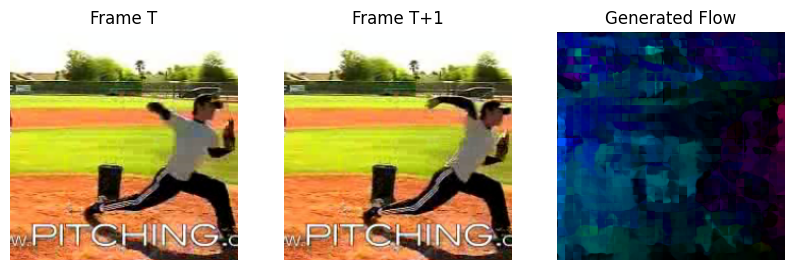

In [49]:
# %%
# CELL 4.5: SANITY CHECK (Run this before Cell 6)

def sanity_check_teacher(device='cuda'):
    print(f"--- Running Sanity Check on {device} ---")
    
    # 1. Setup minimal components
    try:
        # Re-create the transform just for this check
        tfm = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])
        
        # Load Teacher
        teacher = RAFT_Teacher(device)
        
        # Load Dataset in PRETRAIN mode (this tests the neighbor sampling)
        ds = FastHARDataset(CONFIG['dataset_path'], 16, tfm, max_samples=10, mode='pretrain')
        
    except NameError as e:
        print(f"Error: {e}. \nMake sure you have run Cell 2 (Teacher) and Cell 4 (Dataset) first!")
        return

    # 2. Get One Batch
    # 'pair' shape is (6, H, W) -> [Frame_T (3ch), Frame_T+1 (3ch)]
    pair, _ = ds[0] 
    pair = pair.to(device).unsqueeze(0) # Add batch dim -> (1, 6, H, W)
    
    curr = pair[:, :3]
    next_f = pair[:, 3:]
    
    # 3. Predict Flow
    with torch.no_grad():
        flow = teacher(curr, next_f) # (1, 2, H, W)
    
    # 4. Analyze Statistics
    flow_mag = flow.abs()
    mean_val = flow_mag.mean().item()
    max_val = flow_mag.max().item()
    
    print(f"\nStats:")
    print(f"Flow Shape: {flow.shape}")
    print(f"Flow Mean magnitude: {mean_val:.4f} (Target: 0.5 - 10.0)")
    print(f"Flow Max magnitude:  {max_val:.4f}  (Target: < 100.0)")
    
    # 5. Interpretation
    if mean_val > 50:
        print("❌ FAILED: Flow is huge. The frames are likely too far apart (Time Gap bug).")
    elif mean_val < 0.01:
        print("❌ FAILED: Flow is near zero. RAFT inputs might be scaled wrong (Scale bug).")
    else:
        print("✅ PASSED: Flow looks reasonable.")
        
    # 6. Visualize
    rgb_flow = flow_to_rgb(flow[0])
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(curr[0].permute(1,2,0).cpu().numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    plt.title("Frame T")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(next_f[0].permute(1,2,0).cpu().numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    plt.title("Frame T+1")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(rgb_flow)
    plt.title("Generated Flow")
    plt.axis('off')
    plt.show()

# Execute the check
sanity_check_teacher(CONFIG['device'])

In [47]:
# %%
# 6. RUN & VISUALIZE

def visualize_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Val Loss', marker='o')
    plt.title('Loss'); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc', marker='o')
    plt.plot(epochs, history['val_acc'], label='Val Acc', marker='o')
    plt.title('Accuracy'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

def visualize_5_hallucinations(model, dataloader, device):
    model.eval()
    count = 0; max_count = 5
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(10, 15))
    with torch.no_grad():
        for frames, _, _ in dataloader:
            frames = frames.to(device)
            _, meta = model(frames, return_meta=True)
            pred_flows = meta['pred_flow']
            sel_out = meta['sel_out']
            for b in range(frames.shape[0]):
                if count >= max_count: break
                idx_t = sel_out[b, 0].item() 
                rgb = frames[b, idx_t].permute(1,2,0).cpu().numpy()
                rgb = std * rgb + mean; rgb = np.clip(rgb, 0, 1)
                
                flow_tensor = pred_flows[b, 0] 
                rgb_flow = flow_to_rgb(flow_tensor)
                
                plt.subplot(5, 2, count*2 + 1)
                plt.imshow(rgb); plt.title(f"Sample {count+1}: Selected"); plt.axis('off')
                plt.subplot(5, 2, count*2 + 2)
                plt.imshow(rgb_flow); plt.title(f"Sample {count+1}: Hallucinated Flow"); plt.axis('off')
                count += 1
            if count >= max_count: break
    plt.tight_layout(); plt.show()

if __name__ == "__main__":
    trained_model, val_loader, history_data = run_training_pipeline_full()
    visualize_training_curves(history_data)
    visualize_5_hallucinations(trained_model, val_loader, CONFIG['device'])

Using 2 GPUs!
Loading RAFT Teacher (Torchvision)...

=== Stage A: MHN Pretrain ===


MHN Epoch 1: 100%|██████████| 209/209 [02:58<00:00,  1.17it/s]


MHN Loss: 175.0176


MHN Epoch 2:  35%|███▍      | 73/209 [01:06<01:53,  1.20it/s]Exception ignored in: <function VideoReader.__del__ at 0x7e485f3be980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/decord/video_reader.py", line 67, in __del__
    _CAPI_VideoReaderFree(self._handle)
  File "/usr/local/lib/python3.11/dist-packages/decord/_ffi/_ctypes/function.py", line 173, in __call__
    check_call(_LIB.DECORDFuncCall(
               ^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 
MHN Epoch 2:  35%|███▍      | 73/209 [01:07<02:05,  1.09it/s]


KeyboardInterrupt: 

idk ugh

In [ ]:
# ===========================
# RAFT TEACHER (FINAL VERSION)
# ===========================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights

# Normalization buffers
IMNET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
IMNET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

class RAFT_Teacher(nn.Module):
    def __init__(self, device):
        super().__init__()

        print("Loading RAFT Large Teacher (torchvision)...")
        self.weights = Raft_Large_Weights.C_T_SKHT_V2   # Best-performing checkpoint
        self.model = raft_large(weights=self.weights).to(device)
        self.model.eval()

        # Torchvision RAFT transforms (expects 0–255 input)
        self.transforms = self.weights.transforms()

        # Register mean/std buffers on correct device
        self.register_buffer("mean", IMNET_MEAN.to(device))
        self.register_buffer("std", IMNET_STD.to(device))

    @torch.no_grad()
    def forward(self, img1, img2):
        """
        Input:
            img1/img2 → normalized frames in [N,C,H,W] with ImageNet norm
        Output:
            predicted dense flow → [N, 2, H, W]
        """

        # 1. Undo normalization back to [0,1]
        img1_raw = img1 * self.std + self.mean
        img2_raw = img2 * self.std + self.mean

        # 2. Scale to [0,255] → RAFT expected range
        img1_raw = img1_raw * 255.0
        img2_raw = img2_raw * 255.0

        # 3. Apply Torchvision RAFT transforms
        img1_t, img2_t = self.transforms(img1_raw, img2_raw)

        # 4. Run RAFT Teacher
        flows = self.model(img1_t, img2_t)
        flow = flows[-1]     # final refined flow

        # 5. RAFT output must be resized back to original H,W
        if flow.shape[-1] != img1.shape[-1]:
            flow = F.interpolate(flow, size=img1.shape[-2:], mode="bilinear", align_corners=False)

        return flow


In [50]:
# ===========================
# TEST RAFT TEACHER
# ===========================

device = "cuda" if torch.cuda.is_available() else "cpu"
teacher = RAFT_Teacher(device)

# Create fake 2 frames
x1 = torch.randn(1,3,224,224).to(device)
x2 = torch.randn(1,3,224,224).to(device)

flow = teacher(x1, x2)
print("RAFT output shape:", flow.shape)
print("Min:", flow.min().item(), " Max:", flow.max().item())


Loading RAFT Teacher (Torchvision)...
RAFT output shape: torch.Size([1, 2, 224, 224])
Min: -434.1219787597656  Max: 255.221923828125


In [55]:
# CELL 1 — RAFT TEACHER (FIXED)

import torch
import torch.nn as nn
from torchvision.models.optical_flow import raft_large
from torchvision.models.optical_flow import Raft_Large_Weights

class RAFT_Teacher(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        print("Loading RAFT Teacher...")

        weights = Raft_Large_Weights.DEFAULT
        self.model = raft_large(weights=weights).to(device)
        self.model.eval()

        self.device = device

    def forward(self, img1, img2):
        # EXPECTS: img1,img2 in [0–1], NO NORMALIZATION
        with torch.no_grad():
            out = self.model(img1, img2)
        return out[-1]      # flow field

In [58]:
# CELL — FASTHAR Dataset for Videos (Correct)

import cv2
import random
import torch
from torch.utils.data import Dataset
from torchvision import transforms

teacher_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),    # IMPORTANT: NO NORMALIZATION
])

class FastHARDataset(Dataset):
    def __init__(self, root, clip_len=16, transform=None, max_samples=None, mode="pretrain"):
        self.root = root
        self.clip_len = clip_len
        self.transform = transform
        self.mode = mode

        # collect all video files
        import glob
        self.videos = glob.glob(f"{root}/**/*.avi", recursive=True)
        
        if max_samples:
            self.videos = self.videos[:max_samples]

        print(f"[Dataset] Found {len(self.videos)} video files.")

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        vid_path = self.videos[idx]

        cap = cv2.VideoCapture(vid_path)
        frames = []

        # read video frames
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = teacher_transform(Image.fromarray(frame))
            frames.append(frame)
        cap.release()

        # must have ≥ 2 frames
        if len(frames) < 2:
            # fallback: return first frame twice
            img1 = frames[0]
            img2 = frames[0]
        else:
            # pick random t and t+1
            t = random.randint(0, len(frames)-2)
            img1 = frames[t]
            img2 = frames[t+1]

        # return 6-channel tensor
        return torch.cat([img1, img2], dim=0), 0


Running sanity check...
Loading RAFT Teacher...
[Dataset] Found 2 video files.
Flow mean mag: 0.6329
Flow max mag : 14.8563
✅ Looks correct.


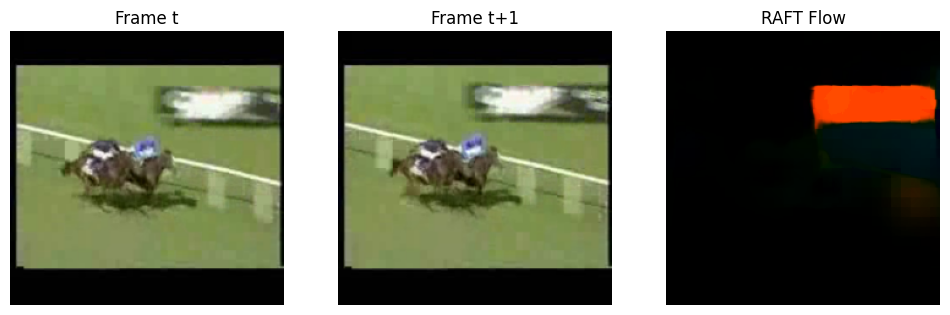

In [59]:
# CELL — SANITY CHECK FOR RAFT + VIDEO DATASET

def sanity_check_teacher(device="cuda"):
    print("Running sanity check...")

    teacher = RAFT_Teacher(device)

    ds = FastHARDataset(
        root='/kaggle/input/realistic-action-recognition-ucf50/UCF50',
        clip_len=16,
        transform=None,
        max_samples=2,
        mode="pretrain"
    )

    pair, _ = ds[0]
    pair = pair.unsqueeze(0).to(device)

    img1 = pair[:, :3]
    img2 = pair[:, 3:]

    with torch.no_grad():
        flow = teacher(img1, img2)

    mag = flow.abs().mean().item()
    mx = flow.abs().max().item()

    print(f"Flow mean mag: {mag:.4f}")
    print(f"Flow max mag : {mx:.4f}")

    if mag < 0.01:
        print("❌ Too small — transform still has normalization OR images are identical.")
    elif mag > 30:
        print("❌ Too large — you applied normalization or scaling error.")
    else:
        print("✅ Looks correct.")

    # visualize
    rgb_flow = flow_to_rgb(flow[0])

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img1[0].permute(1,2,0).cpu().numpy())
    plt.title("Frame t"); plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(img2[0].permute(1,2,0).cpu().numpy())
    plt.title("Frame t+1"); plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(rgb_flow)
    plt.title("RAFT Flow"); plt.axis("off")

    plt.show()

sanity_check_teacher("cuda")

Running Enhanced Sanity Check for RAFT + Video Dataset
Loading RAFT Teacher...
✓ RAFT loaded successfully
[Dataset] Found 2 video files.

📹 Loading video sample 0/2...

🔍 Frame Diagnostics:
  img1 shape: torch.Size([1, 3, 224, 224])
  img1 range: [0.000, 1.000]
  img2 range: [0.000, 1.000]
  Mean absolute difference: 0.020730
  ✓ Frames have visible differences

🌊 Computing optical flow...

📊 Flow Statistics:
  Flow shape: torch.Size([1, 2, 224, 224])
  Mean magnitude: 0.2451 pixels
  Max magnitude: 31.7882 pixels
  U (horizontal) range: [-0.88, 31.79]
  V (vertical) range: [-0.62, 8.81]

✨ Interpretation:
  ✅ Flow magnitude looks reasonable for video motion

🎨 Generating visualization...


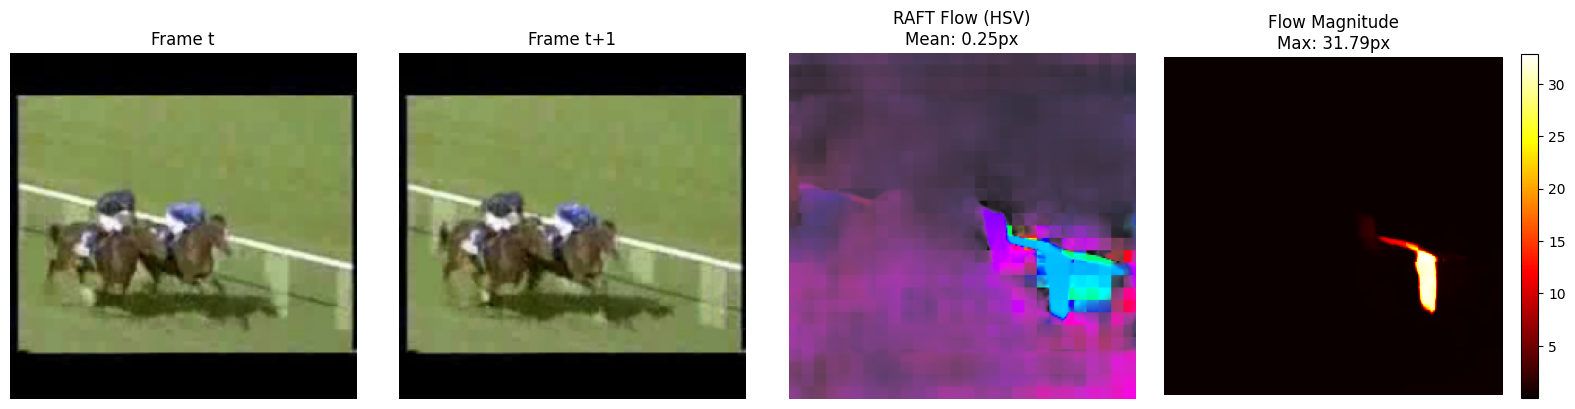


Sanity check complete!


In [60]:
# CELL 1 — IMPORTS
import torch
import torch.nn as nn
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models.optical_flow import raft_large
from torchvision.models.optical_flow import Raft_Large_Weights

# CELL 2 — FLOW VISUALIZATION FUNCTION
def flow_to_rgb(flow):
    """
    Convert optical flow to RGB visualization using HSV color wheel
    Args:
        flow: (2, H, W) tensor [u, v] - horizontal and vertical flow
    Returns:
        rgb: (H, W, 3) numpy array in [0, 1] range
    """
    flow = flow.cpu().numpy()
    u = flow[0]  # horizontal flow
    v = flow[1]  # vertical flow
    
    # Calculate magnitude and angle
    mag = np.sqrt(u**2 + v**2)
    angle = np.arctan2(v, u)
    
    # Normalize angle to [0, 1] for hue
    hue = (angle + np.pi) / (2 * np.pi)
    
    # Normalize magnitude for saturation/value
    # Use 95th percentile for better visualization
    mag_max = np.percentile(mag, 95)
    if mag_max == 0:
        mag_max = 1.0
    saturation = np.clip(mag / mag_max, 0, 1)
    
    # Create HSV image
    hsv = np.zeros((flow.shape[1], flow.shape[2], 3))
    hsv[..., 0] = hue
    hsv[..., 1] = saturation
    hsv[..., 2] = saturation  # Use saturation for value too
    
    # Convert HSV to RGB (manual conversion to avoid cv2 dependency)
    # Or use matplotlib's hsv_to_rgb
    from matplotlib.colors import hsv_to_rgb
    rgb = hsv_to_rgb(hsv)
    
    return rgb

# CELL 3 — RAFT TEACHER
class RAFT_Teacher(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        print("Loading RAFT Teacher...")
        weights = Raft_Large_Weights.DEFAULT
        self.model = raft_large(weights=weights).to(device)
        self.model.eval()
        self.device = device
        print("✓ RAFT loaded successfully")
    
    def forward(self, img1, img2):
        """
        Args:
            img1, img2: (B, 3, H, W) tensors in [0, 1] range
        Returns:
            flow: (B, 2, H, W) optical flow in pixels
        """
        # RAFT expects [0, 1] range (no normalization needed)
        with torch.no_grad():
            flow_predictions = self.model(img1, img2)
        # Return the final refined flow (last in the list)
        return flow_predictions[-1]

# CELL 4 — DATASET
teacher_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # CRITICAL: NO NORMALIZATION
])

class FastHARDataset(Dataset):
    def __init__(self, root, clip_len=16, transform=None, max_samples=None, mode="pretrain"):
        self.root = root
        self.clip_len = clip_len
        self.transform = transform if transform else teacher_transform
        self.mode = mode
        
        # Collect all video files
        import glob
        self.videos = glob.glob(f"{root}/**/*.avi", recursive=True)
        
        if max_samples:
            self.videos = self.videos[:max_samples]
        
        print(f"[Dataset] Found {len(self.videos)} video files.")
        if len(self.videos) == 0:
            print(f"⚠️  WARNING: No .avi files found in {root}")
    
    def __len__(self):
        return len(self.videos)
    
    def __getitem__(self, idx):
        vid_path = self.videos[idx]
        cap = cv2.VideoCapture(vid_path)
        
        if not cap.isOpened():
            print(f"⚠️  WARNING: Cannot open video {vid_path}")
            # Return dummy data
            dummy = torch.zeros(6, 224, 224)
            return dummy, 0
        
        frames = []
        
        # Read video frames
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Apply transform
            frame = self.transform(Image.fromarray(frame))
            frames.append(frame)
        
        cap.release()
        
        # Must have ≥ 2 frames
        if len(frames) < 2:
            print(f"⚠️  WARNING: Video {vid_path} has only {len(frames)} frame(s)")
            # Fallback: return first frame twice
            img1 = frames[0] if frames else torch.zeros(3, 224, 224)
            img2 = img1.clone()
        else:
            # Pick random consecutive frames t and t+1
            t = random.randint(0, len(frames) - 2)
            img1 = frames[t]
            img2 = frames[t + 1]
        
        # Return 6-channel tensor [img1, img2]
        return torch.cat([img1, img2], dim=0), 0

# CELL 5 — ENHANCED SANITY CHECK
def sanity_check_teacher(device="cuda"):
    print("="*60)
    print("Running Enhanced Sanity Check for RAFT + Video Dataset")
    print("="*60)
    
    # Initialize teacher
    teacher = RAFT_Teacher(device)
    
    # Initialize dataset
    ds = FastHARDataset(
        root='/kaggle/input/realistic-action-recognition-ucf50/UCF50',
        clip_len=16,
        transform=None,
        max_samples=2,
        mode="pretrain"
    )
    
    if len(ds) == 0:
        print("❌ ERROR: No videos found in dataset!")
        return
    
    # Get first sample
    print(f"\n📹 Loading video sample 0/{len(ds)}...")
    pair, _ = ds[0]
    pair = pair.unsqueeze(0).to(device)
    
    # Split into two frames
    img1 = pair[:, :3]  # First 3 channels
    img2 = pair[:, 3:]  # Last 3 channels
    
    # Diagnostic information
    print(f"\n🔍 Frame Diagnostics:")
    print(f"  img1 shape: {img1.shape}")
    print(f"  img1 range: [{img1.min():.3f}, {img1.max():.3f}]")
    print(f"  img2 range: [{img2.min():.3f}, {img2.max():.3f}]")
    
    # Check if frames are identical
    diff = (img1 - img2).abs().mean().item()
    print(f"  Mean absolute difference: {diff:.6f}")
    
    if diff < 0.001:
        print("  ⚠️  WARNING: Frames are nearly identical!")
    else:
        print("  ✓ Frames have visible differences")
    
    # Compute optical flow
    print(f"\n🌊 Computing optical flow...")
    with torch.no_grad():
        flow = teacher(img1, img2)
    
    # Flow statistics
    mag = flow.abs().mean().item()
    mx = flow.abs().max().item()
    flow_u = flow[0, 0]  # Horizontal component
    flow_v = flow[0, 1]  # Vertical component
    
    print(f"\n📊 Flow Statistics:")
    print(f"  Flow shape: {flow.shape}")
    print(f"  Mean magnitude: {mag:.4f} pixels")
    print(f"  Max magnitude: {mx:.4f} pixels")
    print(f"  U (horizontal) range: [{flow_u.min():.2f}, {flow_u.max():.2f}]")
    print(f"  V (vertical) range: [{flow_v.min():.2f}, {flow_v.max():.2f}]")
    
    # Interpretation
    print(f"\n✨ Interpretation:")
    if mag < 0.01:
        print("  ❌ Too small — frames are identical OR preprocessing issue")
    elif mag > 30:
        print("  ❌ Too large — normalization or scaling error")
    else:
        print("  ✅ Flow magnitude looks reasonable for video motion")
    
    # Visualization
    print(f"\n🎨 Generating visualization...")
    rgb_flow = flow_to_rgb(flow[0])
    
    # Magnitude map
    magnitude = np.sqrt(flow_u.cpu().numpy()**2 + flow_v.cpu().numpy()**2)
    
    plt.figure(figsize=(16, 4))
    
    plt.subplot(1, 4, 1)
    plt.imshow(img1[0].permute(1, 2, 0).cpu().numpy())
    plt.title("Frame t")
    plt.axis("off")
    
    plt.subplot(1, 4, 2)
    plt.imshow(img2[0].permute(1, 2, 0).cpu().numpy())
    plt.title("Frame t+1")
    plt.axis("off")
    
    plt.subplot(1, 4, 3)
    plt.imshow(rgb_flow)
    plt.title(f"RAFT Flow (HSV)\nMean: {mag:.2f}px")
    plt.axis("off")
    
    plt.subplot(1, 4, 4)
    im = plt.imshow(magnitude, cmap='hot')
    plt.title(f"Flow Magnitude\nMax: {mx:.2f}px")
    plt.colorbar(im, fraction=0.046)
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("Sanity check complete!")
    print("="*60)

# CELL 6 — RUN SANITY CHECK
if __name__ == "__main__":
    sanity_check_teacher("cuda")

In [78]:
# %%
# 4. RUN PIPELINE

def run_pipeline():
    set_seed(CONFIG['seed'])
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    device = CONFIG['device']
    
    # Models
    base_model = DS_STT_AFO(CONFIG['num_classes'], CONFIG['frames_to_select']).to(device)
    teacher = RAFT_Teacher(device)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(base_model); teacher = nn.DataParallel(teacher)
    else: model = base_model

    scaler = GradScaler('cuda')
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    best_val = -1.0

    # --- STAGE A ---
    print("\n>>> Stage A: MHN Pretrain")
    ds_pre = FastHARDataset(CONFIG['dataset_path'], 16, None, CONFIG['max_samples'], mode='pretrain')
    dl_pre = DataLoader(ds_pre, CONFIG['batch_size'], shuffle=True, num_workers=4)
    opt = optim.AdamW(base_model.mhn.parameters(), lr=CONFIG['lr'])
    
    for ep in range(CONFIG['epochs_mhn_pretrain']):
        base_model.mhn.train()
        pbar = tqdm(dl_pre, desc=f"Ep {ep+1}")
        total_loss = 0; valid = 0
        
        for norm_pair, raw_pair, _ in pbar:
            norm_pair = norm_pair.to(device)
            raw_pair = raw_pair.to(device)
            if norm_pair.sum() == 0: continue
            
            with autocast('cuda'):
                pred = base_model.mhn(norm_pair)
                with torch.no_grad(): 
                    # Raw pair has [img1, img2] in channels
                    target = teacher(raw_pair[:,:3], raw_pair[:,3:])
                
                mag = target.abs().mean().item()
                if mag > 30.0: 
                    pbar.set_postfix({'status': 'SKIPPED', 'mag': f"{mag:.1f}"})
                    continue 
                
                loss = flow_epe_loss(pred, target)
            
            scaler.scale(loss).backward(); scaler.step(opt); scaler.update(); opt.zero_grad()
            total_loss += loss.item(); valid += 1
            pbar.set_postfix({'loss': f"{loss.item():.2f}", 'mag': f"{mag:.1f}"})
            
        print(f"Avg Loss: {total_loss/(valid+1e-8):.4f}")

    # --- STAGE B/C ---
    ds = FastHARDataset(CONFIG['dataset_path'], 16, None, CONFIG['max_samples'], mode='full')
    tr_sz = int(0.8*len(ds)); tr_ds, val_ds = random_split(ds, [tr_sz, len(ds)-tr_sz])
    tr_dl = DataLoader(tr_ds, CONFIG['batch_size'], shuffle=True, num_workers=4)
    val_dl = DataLoader(val_ds, CONFIG['batch_size'], shuffle=False, num_workers=4)

    print("\n>>> Stage B: Warmup")
    for p in base_model.mhn.parameters(): p.requires_grad = False
    opt = optim.AdamW([p for p in base_model.parameters() if p.requires_grad], lr=CONFIG['lr'])
    
    for stage_name, epochs in [('B', CONFIG['epochs_classifier']), ('C', CONFIG['epochs_finetune'])]:
        if stage_name == 'C':
            print("\n>>> Stage C: Finetune"); 
            for p in base_model.mhn.parameters(): p.requires_grad = True
            opt = optim.AdamW(base_model.parameters(), lr=CONFIG['lr']*0.1)

        for ep in range(epochs):
            model.train(); tr_corr=0; tr_tot=0
            pbar = tqdm(tr_dl, desc=f"{stage_name} Ep {ep+1}")
            for f, raw_f, l, _ in pbar:
                f, l = f.to(device), l.to(device)
                if f.sum() == 0: continue
                with autocast('cuda'):
                    logits, meta = model(f, return_meta=True)
                    loss = criterion(logits, l) + 0.01 * entropy_sparsity_loss(meta['sel_out'])
                    if stage_name == 'C': 
                        s_flow = rearrange(meta['pred_flow'], 'b k c h w -> (b k) c h w')
                        sel = meta['sel_out']
                        raw_f = raw_f.to(device)
                        
                        # Gather RAW frames for teacher
                        raw_flat_curr = rearrange(raw_f[torch.arange(f.size(0)).unsqueeze(1), sel], 'b k c h w -> (b k) c h w')
                        raw_flat_next = rearrange(raw_f[torch.arange(f.size(0)).unsqueeze(1), torch.clamp(sel+1, max=15)], 'b k c h w -> (b k) c h w')
                        
                        with torch.no_grad(): t_flow = teacher(raw_flat_curr, raw_flat_next)
                        if t_flow.abs().mean() < 30.0:
                            loss += 0.5 * flow_epe_loss(s_flow, t_flow)

                scaler.scale(loss).backward(); scaler.step(opt); scaler.update(); opt.zero_grad()
                tr_corr += (logits.argmax(1)==l).sum().item(); tr_tot += l.size(0)
                pbar.set_postfix({'acc': f"{100*tr_corr/tr_tot:.1f}%"})
            
            # Validation
            model.eval(); val_corr=0; val_tot=0
            with torch.no_grad():
                for f, _, l, _ in val_dl:
                    f, l = f.to(device), l.to(device)
                    if f.sum() == 0: continue
                    val_corr += (model(f).argmax(1)==l).sum().item(); val_tot += l.size(0)
            acc = 100*val_corr/val_tot
            print(f"Val Acc: {acc:.2f}%")
            history['train_acc'].append(100*tr_corr/tr_tot); history['val_acc'].append(acc)
            if acc > best_val: best_val = acc; torch.save(base_model.state_dict(), f"{CONFIG['save_dir']}/best.pth")

    return model, val_dl, history

if __name__ == "__main__":
    trained_model, val_dl, hist = run_pipeline()
    
    # Visualize Flow
    trained_model.eval(); 
    f, _, _, _ = next(iter(val_dl)); f = f.to(CONFIG['device'])
    if isinstance(trained_model, nn.DataParallel): _, meta = trained_model.module(f, return_meta=True)
    else: _, meta = trained_model(f, return_meta=True)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(f[0, meta['sel_out'][0,0]].permute(1,2,0).cpu().numpy()*0.229+0.485); plt.title("Frame")
    plt.subplot(1,2,2); plt.imshow(flow_to_rgb(meta['pred_flow'][0,0])); plt.title("Hallucinated Flow")
    plt.show()

Loading RAFT Teacher...

>>> Stage A: MHN Pretrain


TypeError: FastHARDataset.__init__() got multiple values for argument 'mode'